In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd
from bisect import *
from decimal import Decimal
# from scipy.optimize import curve_fit

In [5]:
layerStart = [0,96,320,672,1184,1296,1408,1520,1632,1744,1856]
layerName = ["BL1","BL2","BL3","BL4","E+1", "E+2", "E+3","E-1", "E-2", "E-3"]
def layer(x) :
    return bisect_right(layerStart, x)

print(layer(0),layer(1),layer(95),layer(96),layer(97),layer(1743),layer(1744),layer(1855))

i2p = math.pi/32769.0

1 1 1 2 2 9 10 10


In [6]:
def curvature(h, ptmin, region_origin_radius,hardPtCut, first, rad=False) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
    y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
    x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
    y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
    x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
    y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*87 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
        if rad: return radius
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius # - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [7]:
def dca(h, first, curv=False):
    
   x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
   y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
   x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
   y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
   x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
   y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
 
    
   noflip = abs(x3-x1) < abs(y3-y1)
   x1p = np.where(noflip, x1-x2, y1-y2)
   y1p = np.where(noflip, y1-y2, x1-x2)
   d12 = x1p*x1p + y1p*y1p
   x3p = np.where(noflip, x3-x2, y3-y2)
   y3p = np.where(noflip, y3-y2, x3-x2)
   d32 = x3p*x3p + y3p*y3p
   num = x1p*y3p-y1p*x3p  # num also gives correct sign for CT
   det = d12*y3p-d32*y1p

   st2 = d12*x3p-d32*x1p
   seq = det*det +st2*st2
   al2 = 1./np.sqrt(seq)
   be2 = -st2*al2
   ct = 2.*num*al2
   al2 *=det
   m_xp = x2
   m_yp = y2
   m_c = np.where(noflip, ct, -ct)
   m_alpha = np.where(noflip, al2, -be2)
   m_beta  = np.where(noflip, be2, -al2)

   if curv : return m_c
    
   x =  m_c*m_xp + m_alpha
   y =  m_c*m_yp + m_beta
   return (np.sqrt(x*x+y*y) - 1.)/m_c
    

In [8]:
def deltaphi(a,b,ch) :
    ch *=ch
    cb = ch*b
    ca = ch*a
    return np.arcsin(cb) - np.arcsin(ca)


def deltaphiA(a,b,ch) :
    ch *=ch
    d = b-a
    cd = ch*d
    ca = ch*a
    return cd*(1.+0.5*ca*(ca+cd)+cd*cd*0.1667)


def eta(r,z) :
    t = z/r
    return np.arcsinh(t);

def sag(r,c) :
    return 0.5*c*r*r

def phicutOld(a,b,c) :
    o = np.maximum(a,b)
    i = np.minimum(a,b)
    d = np.minimum(i,o-i)
    m = sag(o,c)
    return d*m/(0.5*o*i)

def phicut(a,b,c) :
   ro = np.maximum(a,b)
   ri = np.minimum(a,b)
   dr = ro-ri
   return dr/np.sqrt(4./(c*c) -ri*ro);

def zAtR(h,r) :
    zi = h['z1']
    zo = h['z3']
    ri = h['r1']
    ro = h['r3']
    return zi + (r-ri)*(zo-zi)/(ro-ri)

def etaTk(h) :
    return eta(h['r2']-h['r1'],h['z2']-h['z1'])


In [9]:
def alignRZ(h, rp, ptmin, first) :
    '''
    float radius_diff = std::abs(r1 - ro);
    float distance_13_squared = radius_diff*radius_diff + (z1 - zo)*(z1 - zo);
    
    float pMin = ptmin*std::sqrt(distance_13_squared); //this needs to be divided by radius_diff later
    
    float tan_12_13_half_mul_distance_13_squared = fabs(z1 * (getInnerR() - ro) + getInnerZ() * (ro - r1) + zo * (r1 - getInnerR())) ;
    return tan_12_13_half_mul_distance_13_squared * pMin <= thetaCut * distance_13_squared * radius_diff;
    '''
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
    fact = 1. if (rp=='r') else 10.
    radius_diff = fact*abs(ri - ro)
    distance_13_squared = radius_diff*radius_diff + (zi - zo)*(zi - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = fact*abs(zi * (rm - ro) + zm * (ro - ri) + zo * (ri - rm)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [10]:
def alignRPZ(h, rp, first) :
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
     
    return (rm-ri)*(zo-zm) - (ro-rm)*(zm-zi)

In [11]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

In [12]:
def ml(pt1,pz1,pt2,pz2) :
    dp = pt1*pt2+pz1*pz2
    m1 = pt1*pt1+pz1*pz1
    m2 = pt2*pt2+pz2*pz2
    corr =  pt1/np.sqrt(m1)
    dp /=np.sqrt(m1*m2)
    dt = np.arccos(dp[dp<1]) 
    dtn = dt*np.sqrt(m1)*corr
    return dt,dtn

In [13]:
# file = '/Users/innocent/data/openDataHits.csv'
#file = '/Users/innocent/data/zeeHits.csv'
file = '/Users/innocent/data/flatMuonHits.csv'
# file = '/Users/innocent/data/SingleMuon50Ideal.csv'
# file = '/Users/innocent/data/ttbarIdealPU50HitsC2.csv'
# file = '/Users/innocent/data/ttbarPU50Hits.csv'
# file = '/Users/innocent/data/ttbarPU0Hits.csv'
rawHits = pd.read_csv(file, delimiter=" ")
print ('#rawhits', len(rawHits))

#rawhits 444666


In [14]:
ptCut = 10000 #400
rawHits['phi'] =  np.arctan2(rawHits['yg'],rawHits['xg']) # rawHits['iphi']*i2p
rawHits['etah'] =  eta(rawHits['rg'],rawHits['zg'])
rawHits['seq'] = rawHits['det'].apply(layer)
rawHits['trackID'] = rawHits['tkId']+10000000*rawHits['ev']
rawHits['norm'] = 1./1000.
rawHits.sort_values(by=['ev','tkId','det'],inplace=True)
hits =  rawHits[np.logical_and(np.logical_and(rawHits['pt']>ptCut, abs(rawHits['z0'])<150000),rawHits['r0']<1000)]
print ('#hits', len(hits))
print (hits.head())
print (hits.tail())

#hits 361284
    ev  ind   det  charge      xg       yg       zg       rg   iphi  xsize  \
10   1    1    59   40505 -1.3943  -2.4623  -0.2417   2.8297 -21759      8   
12   1    3   243   36074 -3.4097  -6.0428  -5.1419   6.9384 -21743     15   
14   1    5   554   41296 -5.2655  -9.3243  -9.6391  10.7083 -21747     10   
16   1    7  1009   30669 -7.7874 -13.7713 -15.7406  15.8207 -21753     16   
9    1    0    12   47714  1.3871   2.4693   6.5181   2.8322  11045      8   

    ...     pt    eta     z0  r0  n1       phi      etah  seq   trackID   norm  
10  ...  48872 -10115  31398  33   3 -2.086037 -0.085312    1  10000000  0.001  
12  ...  48872 -10115  31398  33   4 -2.084520 -0.685995    2  10000000  0.001  
14  ...  48872 -10115  31398  33   4 -2.084861 -0.808980    3  10000000  0.001  
16  ...  48872 -10115  31398  33   3 -2.085447 -0.877789    4  10000000  0.001  
9   ...  48872  10115  31398  33   3  1.058986  1.570847    1  10000001  0.001  

[5 rows x 22 columns]
         

In [15]:
def posBar(hh) :
    return hh.seq()<5 & 1==(hh.det()%8)/4

print (hits.query('seq<5 & 1==((det%8)/4)').head())
print (hits.query('seq>7').head())


    ev  ind  det  charge      xg      yg      zg       rg   iphi  xsize  ...  \
9    1    0   12   47714  1.3871  2.4693  6.5181   2.8322  11045      8  ...   
1    2    1   84   49473  2.4421 -1.8713  3.4324   3.0766  -6821     11  ...   
59   6    3  220   33813 -5.9870 -2.7759  4.6873   6.5992 -28240     13  ...   
61   6    5  524   39745 -9.7357 -4.5097  1.6396  10.7295 -28243     15  ...   
66   7    1   44   30675 -2.8515 -0.1110  1.9528   2.8536 -32363     -8  ...   

       pt    eta     z0  r0  n1       phi      etah  seq   trackID   norm  
9   48872  10115  31398  33   3  1.058986  1.570847    1  10000001  0.001  
1   25912  12352 -14087  17   4 -0.653831  0.960831    1  20000000  0.001  
59  74251  -6835  95596  12   3 -2.707442  0.661070    2  60000000  0.001  
61  74251  -6835  95596  12   2 -2.707806  0.152224    3  60000000  0.001  
66  36969  -8980  48768  16   2 -3.102685  0.639781    1  70000000  0.001  

[5 rows x 22 columns]
    ev  ind   det  charge      xg      y

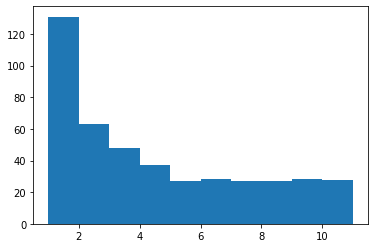

[130.912  63.399  47.84   37.233  27.14   28.387  27.105  27.116  28.125
  27.409]
All Hits 4.4467E+02
[8299.689888000335, 3033.008160000388, 1781.2267200001982, 3552.9516799997314, 1720.6488599999295, 1298.3776000000155, 770.4231799998893, 769.4296349998895, 3549.8097919997267, 1719.1272839999274, 1297.2294400000137, 762.6374999998873, 770.8781249998896, 0]
All Doublets 2.9325E+04


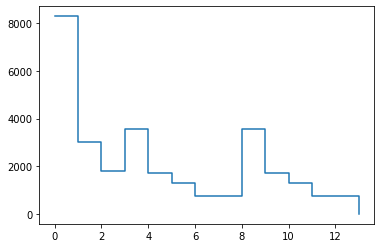

All triplets [397057.1642419719, 112927.99282129682, 225253.5835603114, 82315.84146240407, 100857.6393401458, 20882.32029389536, 48844.05918881481, 225054.39100299912, 82243.04926656396, 99838.40039998553, 20903.131237495334, 48350.45486249467, 0]
1.4645E+06


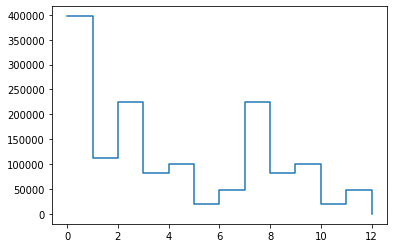

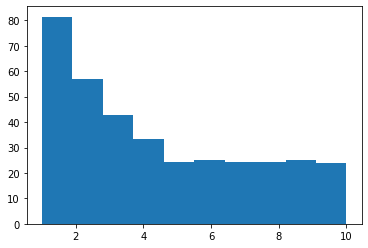

In [16]:
#print hits[hits['tkId']==3].head(50)
n,b,p = plt.hist(rawHits['seq'],weights=rawHits['norm'])
plt.show()
print (n) 
print ('All Hits', '{:.4E}'.format(np.sum(n)))
doublets = [n[0]*n[1],n[1]*n[2],n[2]*n[3],
            n[0]*n[4],n[1]*n[4],n[2]*n[4],n[4]*n[5],n[5]*n[6],
            n[0]*n[7],n[1]*n[7],n[2]*n[7],n[7]*n[8],n[8]*n[9],0
            ]
print (doublets)
print ('All Doublets', '{:.4E}'.format(np.sum(doublets)))
xy = np.arange(0.,14.,1.)
plt.step(xy,doublets,where='post')
plt.show()
triplets = [n[0]*n[1]*n[2],n[1]*n[2]*n[3],
            n[0]*n[1]*n[4],n[1]*n[2]*n[4],
            n[0]*n[4]*n[5],n[4]*n[5]*n[6],
            n[1]*n[4]*n[5],
            n[0]*n[1]*n[7],n[1]*n[2]*n[7],
            n[0]*n[7]*n[8],n[7]*n[8]*n[9],
            n[1]*n[7]*n[8],0
            ]
print ('All triplets', triplets)
print ('{:.4E}'.format(np.sum(triplets)))
xy = np.arange(0.,len(triplets),1)
plt.step(xy,triplets,where='post')
plt.show()


plt.hist(hits['seq'],weights=hits['norm'])
plt.show()

81435 56764 42920 33410 48346 50242 48167


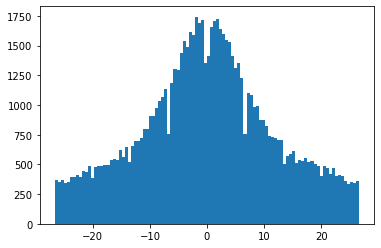

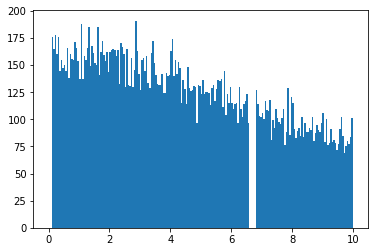

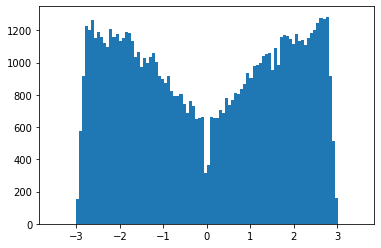

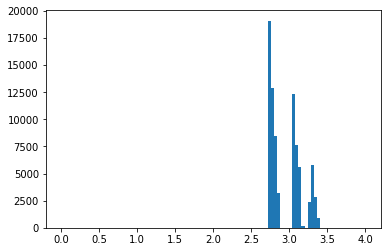

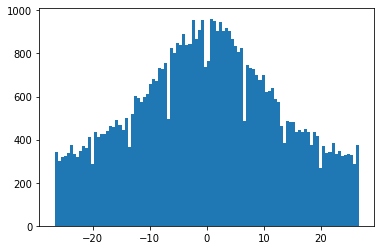

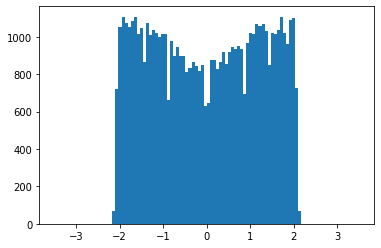

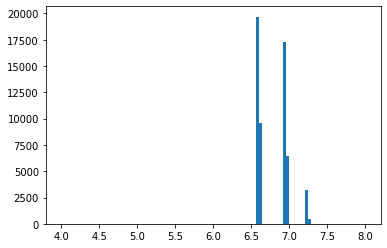

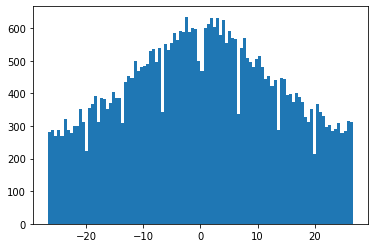

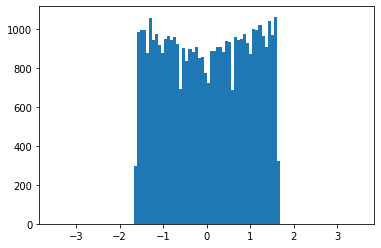

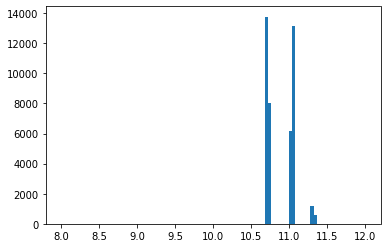

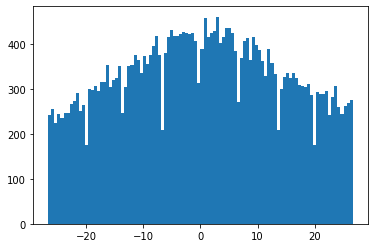

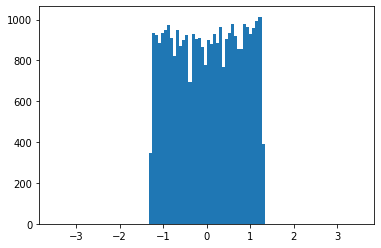

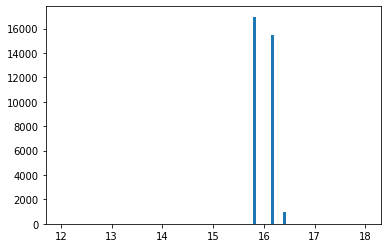

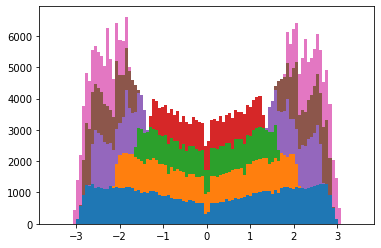

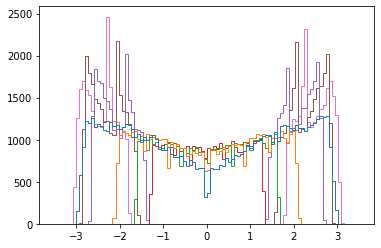

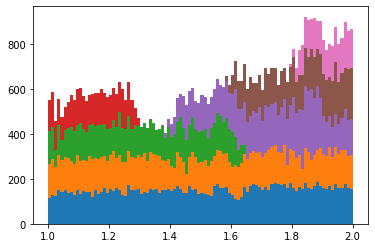

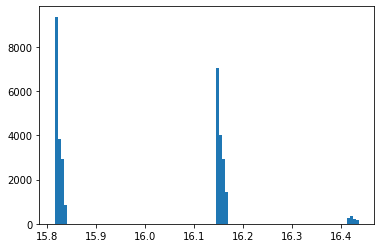

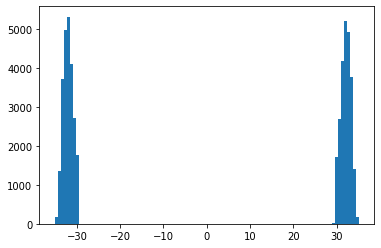

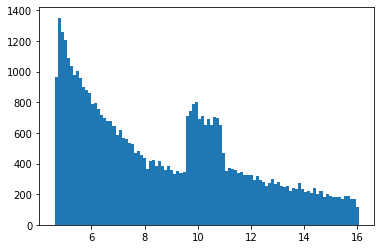

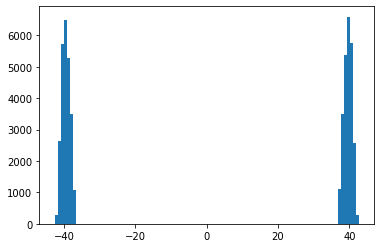

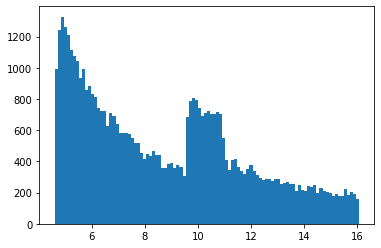

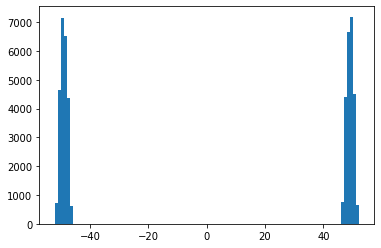

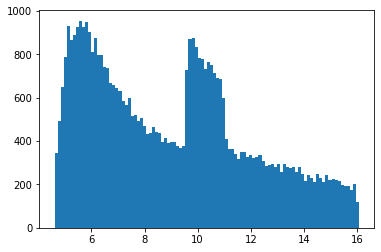

In [17]:
hb1 = hits.query('seq==1')
hb2 = hits.query('seq==2')
hb3 = hits.query('seq==3')
hb4 = hits.query('seq==4')
hf1 = hits.query('seq==5 or seq==8')
hf2 = hits.query('seq==6 or seq==9')
hf3 = hits.query('seq==7 or seq==10')

print (len(hb1), len(hb2), len(hb3), len(hb4), len(hf1), len(hf2), len(hf3))
plt.hist(hb1['zg'],log=False, bins=100)
plt.show()
plt.hist(hb1['zg'],log=False, bins=200,range=[0,10])
plt.show()
plt.hist(hb1['etah'],log=False, bins=100,range=[-3.5,3.5])
plt.show()
plt.hist(hb1['rg'],log=False, bins=100,range=[0,4])
plt.show()
plt.hist(hb2['zg'],log=False, bins=100)
plt.show()
plt.hist(hb2['etah'],log=False, bins=100,range=[-3.5,3.5])
plt.show()
plt.hist(hb2['rg'],log=False, bins=100,range=[4,8])
plt.show()
plt.hist(hb3['zg'],log=False, bins=100)
plt.show()
plt.hist(hb3['etah'],log=False, bins=100,range=[-3.5,3.5])
plt.show()
plt.hist(hb3['rg'],log=False, bins=100,range=[8,12])
plt.show()
plt.hist(hb4['zg'],log=False, bins=100)
plt.show()
plt.hist(hb4['etah'],log=False, bins=100,range=[-3.5,3.5])
plt.show()
plt.hist(hb4['rg'],log=False, bins=100,range=[12,18])
plt.show()
data = [hb1['etah'],hb2['etah'],hb3['etah'],hb4['etah'],hf1['etah'],hf2['etah'],hf3['etah']]
plt.hist(data,log=False, bins=100, histtype='barstacked',range=[-3.5,3.5])
plt.show()
plt.hist(data,log=False, bins=100, histtype='step',range=[-3.5,3.5])
plt.show()
plt.hist(data,log=False, bins=100, range=[1,2], histtype='barstacked',)
plt.show()


plt.hist(hb4['rg'],log=False, bins=100)
plt.show()
plt.hist(hf1['zg'],log=False, bins=100)
plt.show()
plt.hist(hf1['rg'],log=False, bins=100)
plt.show()
plt.hist(hf2['zg'],log=False, bins=100)
plt.show()
plt.hist(hf2['rg'],log=False, bins=100)
plt.show()
plt.hist(hf3['zg'],log=False, bins=100)
plt.show()
plt.hist(hf3['rg'],log=False, bins=100)
plt.show()


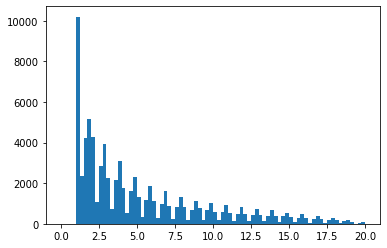

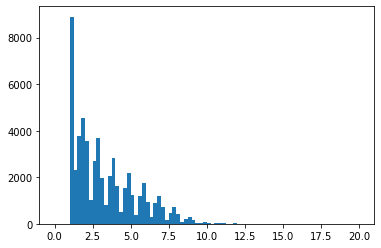

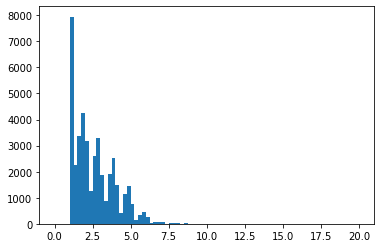

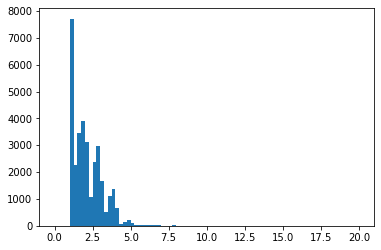

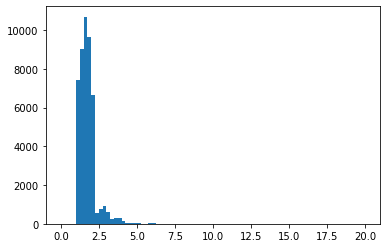

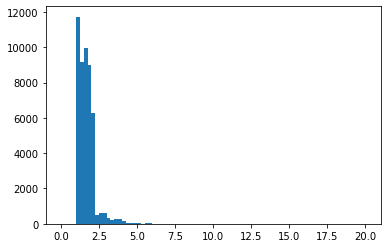

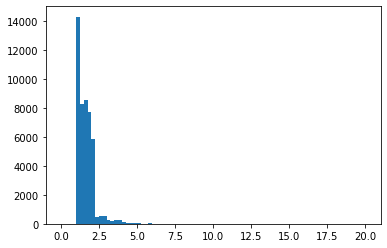

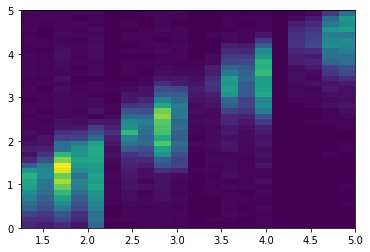

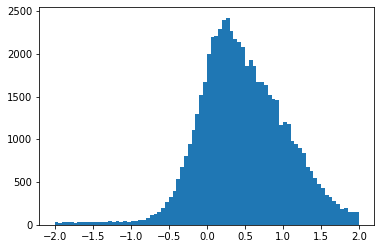

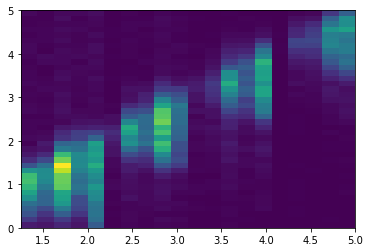

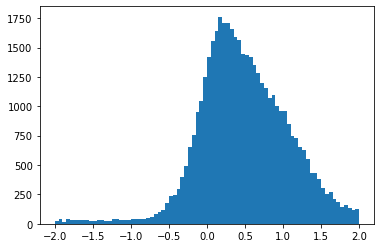

In [18]:
plt.hist(hb1['ysize']/8.,log=False, bins=80,range=[0,20])
plt.show()
plt.hist(hb2['ysize']/8.,log=False, bins=80,range=[0,20])
plt.show()
plt.hist(hb3['ysize']/8.,log=False, bins=80,range=[0,20])
plt.show()
plt.hist(hb4['ysize']/8.,log=False, bins=80,range=[0,20])
plt.show()
plt.hist(hf1['ysize']/8.,log=False, bins=80,range=[0,20])
plt.show()
plt.hist(hf2['ysize']/8.,log=False, bins=80,range=[0,20])
plt.show()
plt.hist(hf3['ysize']/8.,log=False, bins=80,range=[0,20])
plt.show()

def scut(hh) :
    return hh.query('ysize>8')

b1 = scut(hb1)
b2 = scut(hb2)
plt.hist2d(hb1['ysize']/8.,abs(285./150.*(hb1['zg']-hb1['z0']/10000.)/hb1['rg']),bins=[20,40],range=[[1.25,5],[0,5]])
plt.show()
plt.hist(b1['ysize']/8.-abs(285./150.*(b1['zg']-b1['z0']/10000.)/b1['rg']),bins=80,range=[-2.,2.])
plt.show()
plt.hist2d(hb2['ysize']/8.,abs(285./150.*(hb2['zg']-hb2['z0']/10000.)/hb2['rg']),bins=[20,40],range=[[1.25,5],[0,5]])
plt.show()
plt.hist(b2['ysize']/8.-abs(285./150.*(b2['zg']-b2['z0']/10000.)/b2['rg']),bins=80,range=[-2.,2.])
plt.show()


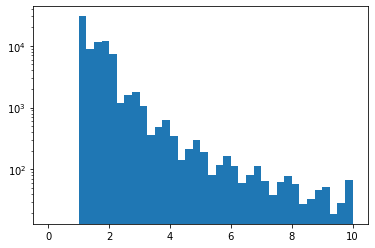

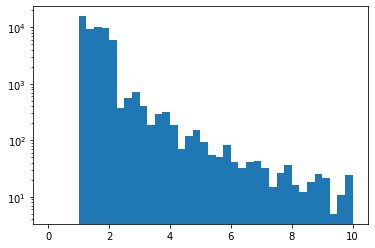

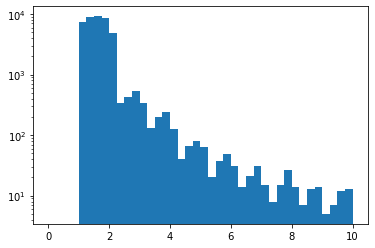

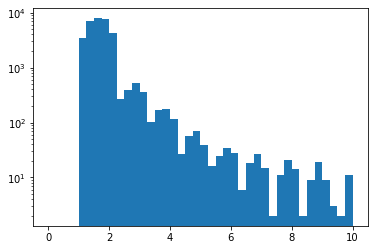

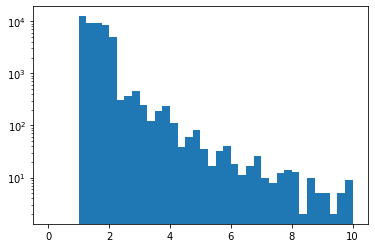

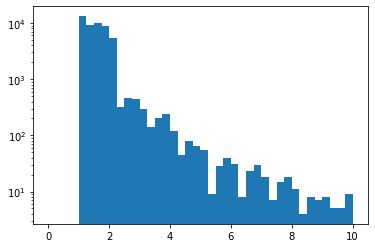

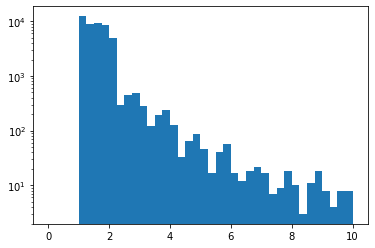

In [19]:
def ptcut(hh) :
    return hh.query('pt>500')

plt.hist(ptcut(hb1)['xsize']/8.,log=True, bins=40,range=[0,10])
plt.show()
plt.hist(ptcut(hb2)['xsize']/8.,log=True, bins=40,range=[0,10])
plt.show()
plt.hist(ptcut(hb3)['xsize']/8.,log=True, bins=40,range=[0,10])
plt.show()
plt.hist(ptcut(hb4)['xsize']/8.,log=True, bins=40,range=[0,10])
plt.show()
plt.hist(ptcut(hf1)['xsize']/8.,log=True, bins=40,range=[0,10])
plt.show()
plt.hist(ptcut(hf2)['xsize']/8.,log=True, bins=40,range=[0,10])
plt.show()
plt.hist(ptcut(hf3)['xsize']/8.,log=True, bins=40,range=[0,10])
plt.show()



In [20]:
print ('min/max')
print (hb1.agg(['min','max']))
print (hb2.agg(['min','max']))
print (hb3.agg(['min','max']))
print (hb4.agg(['min','max']))
print (hf1.agg(['min','max']))
print (hf2.agg(['min','max']))
print (hf3.agg(['min','max']))

min/max
        ev  ind  det   charge      xg       yg       zg      rg   iphi  xsize  \
min      1    0    0        0 -3.1587 -24.2935 -26.6751  0.0000 -32761   -328   
max  39996   32   95  2420777  3.1587  26.0660  26.6750  3.3744  32765    437   

     ...      pt    eta      z0  r0   n1       phi      etah  seq  \
min  ...   10001 -29988 -149966   0    1 -3.141026 -2.971874    1   
max  ...  100009  29995  148175  72  165  3.141416       inf    1   

          trackID   norm  
min      10000000  0.001  
max  399960000001  0.001  

[2 rows x 22 columns]
        ev  ind  det   charge      xg      yg       zg      rg   iphi  xsize  \
min      1    0   96     4029 -6.9806 -7.2495 -26.6751  6.5775 -32762   -197   
max  39996   49  319  1140668  6.9806  7.2495  26.6750  7.2504  32765    575   

     ...      pt    eta      z0  r0  n1       phi      etah  seq  \
min  ...   10001 -24475 -149135   0   1 -3.141139 -2.107793    2   
max  ...  100009  24568  148175  72  74  3.141472  2.107966

In [21]:
def build(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['zg'],
                    'r'+n : hh['rg'],
                    'phi'+n : hh['phi'],
                    'ys'+n : hh['ysize'],
                    'pt'+n : hh['pt'],
                    'eta'+n : hh['eta'],
                    'det'+n : hh['det'],
                    'trackID' : hh['trackID'],
                    'tkz'+n : hh['z0']/10000.,
                    'seq'+n : hh['seq'],
                       })

def buildXYZ(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['zg'],
                    'x'+n : hh['xg'],
                    'y'+n : hh['yg'],
                    'pt'+n : hh['pt'],
                    'eta'+n : hh['eta'],
                    'det'+n : hh['det'],
                    'phi'+n : hh['phi'],
                    'trackID' : hh['trackID']
                       })


In [22]:
def fishBone(hi,hj) :
    mpt=600
#    maxc = 1000./(mpt*87.)
    fb = pd.merge(pd.merge(buildXYZ(hi,'0'),buildXYZ(hj,'1'),on='trackID'),buildXYZ(hj,'2'),on='trackID')
#    pc = phicut(quadc['r1'],quadc['r2'],maxc)
#  d1 = (quadc['phi2']-quadc['phi1'])/pc
    cut = np.logical_and(abs(fb['phi0']-fb['phi1'])<0.05,abs(fb['phi0']-fb['phi2'])<0.05)
    cut = np.logical_and(cut,fb['pt0']>mpt)
    return fb[np.logical_and(cut,fb['det1']<fb['det2'])]
    
def sdiff(fb) :
    n1 = (fb['x1']-fb['x0'])*(fb['x1']-fb['x0'])+\
    (fb['y1']-fb['y0'])*(fb['y1']-fb['y0'])+\
    (fb['z1']-fb['z0'])*(fb['z1']-fb['z0'])
    n2 = (fb['x2']-fb['x0'])*(fb['x2']-fb['x0'])+\
    (fb['y2']-fb['y0'])*(fb['y2']-fb['y0'])+\
    (fb['z2']-fb['z0'])*(fb['z2']-fb['z0'])
    pr = (fb['x1']-fb['x0'])*(fb['x2']-fb['x0'])+\
      (fb['y1']-fb['y0'])*(fb['y2']-fb['y0'])+\
      (fb['z1']-fb['z0'])*(fb['z2']-fb['z0'])
    return pr/np.sqrt(n1*n2)

In [23]:
def plotFB(h1,h2) :
  f12 = fishBone(h1,h2)
  # print f12.head()
  d = sdiff(f12)
  plt.hist(d, bins=100,log=True)
  plt.show()
  plt.hist(d[d>.995], bins=100,log=True)
  plt.show()
  plt.hist(d[d>.9999], bins=100,log=True)
  plt.show()

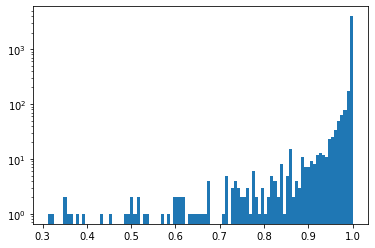

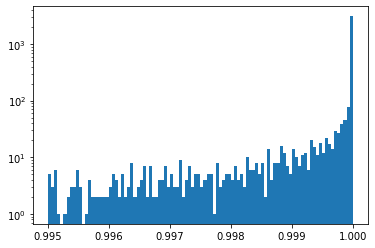

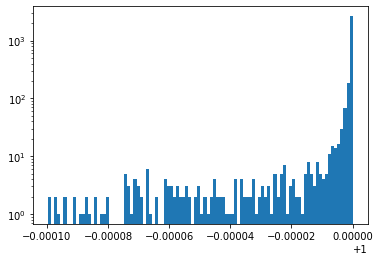

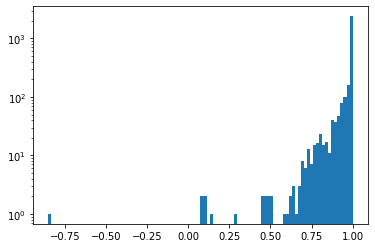

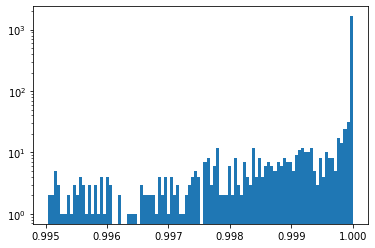

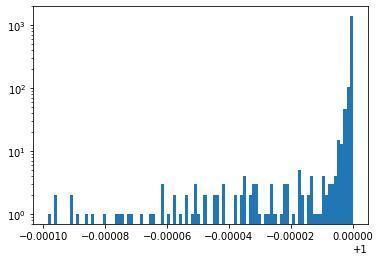

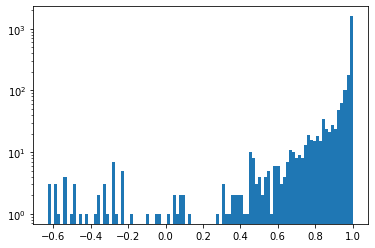

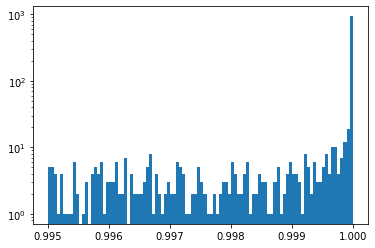

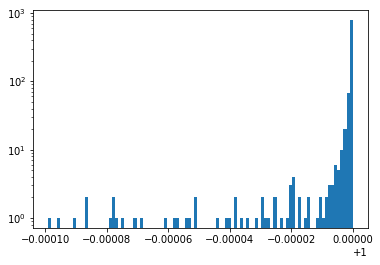

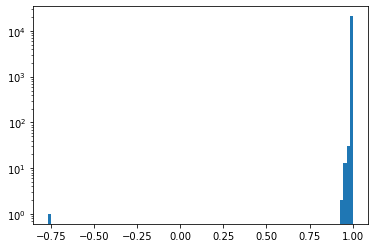

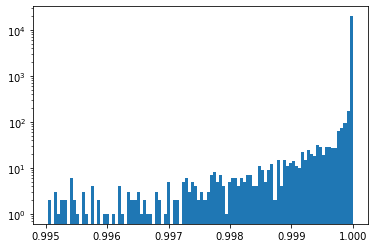

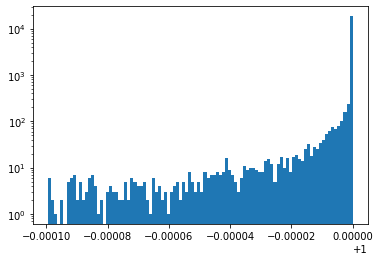

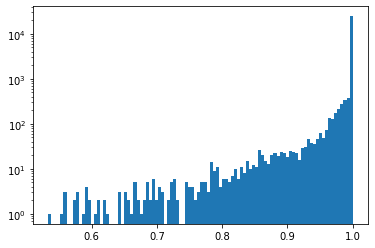

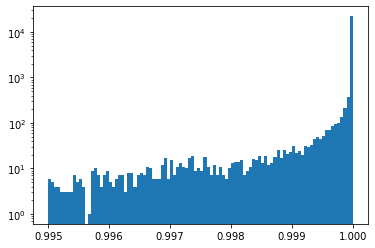

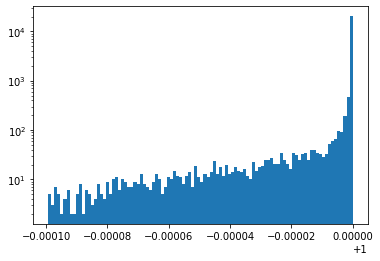

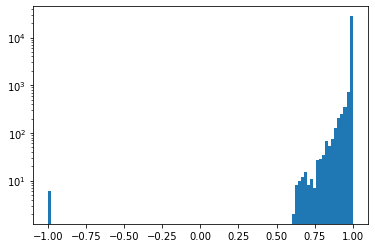

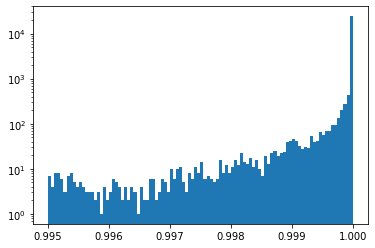

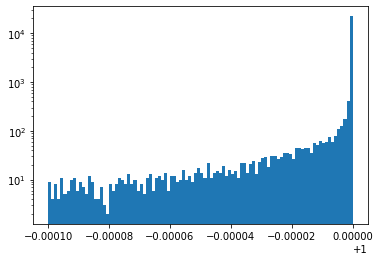

In [24]:
plotFB(hb1,hb2)
plotFB(hb2,hb3)
plotFB(hb3,hb4)
plotFB(hb1,hf1)
plotFB(hf1,hf2)
plotFB(hf2,hf3)

In [25]:
t12 = pd.merge(build(hb1,'1'),build(hb2,'2'),on='trackID')
t23 = pd.merge(build(hb2,'1'),build(hb3,'2'),on='trackID')
t34 = pd.merge(build(hb3,'1'),build(hb4,'2'),on='trackID')

print ('doublets')
print (len(t12))
print (len(t23))
print (len(t34))

t11 = pd.merge(build(hb1,'1'),build(hf1,'2'),on='trackID')
print (len(t11))

t21 = pd.merge(build(hb2,'1'),build(hf1,'2'),on='trackID')
print (len(t21))
t31 = pd.merge(build(hb3,'1'),build(hf1,'2'),on='trackID')
print (len(t31))

t12f = pd.merge(build(hf1,'1'),build(hf2,'2'),on='trackID')
print (len(t12f))
t23f = pd.merge(build(hf2,'1'),build(hf3,'2'),on='trackID')
print (len(t23f))

lpairs = [t12,t23,t34,t11,t21,t31,t12f,t23f]
cpairs = pd.concat(lpairs)
cpairs['nhits'] = 2.

print ('triplets and quads')
t123 = pd.merge(t12,build(hb3,'3'),on='trackID')
print (len(t123))
t1234 = pd.merge(t123,build(hb4,'4'),on='trackID')
print (len(t1234))
t1231 = pd.merge(t123,build(hf1,'4'),on='trackID')
print (len(t1231))
t121 = pd.merge(t12,build(hf1,'3'),on='trackID')
t1212 = pd.merge(t121,build(hf2,'4'),on='trackID')
print (len(t1212))
t112 = pd.merge(t11,build(hf2,'3'),on='trackID')
t1123 = pd.merge(t112,build(hf3,'4'),on='trackID')
print (len(t1123))
trin = pd.concat([t123,t121,t112])
trin['nhits'] = 3.
qall = pd.concat([t1234,t1231,t1212,t1123])
qall['nhits'] = 4.
print (len(qall))

print ('pentuplets')
t12312 = pd.merge(t1231,build(hf2,'5'),on='trackID')
t12123 = pd.merge(t1212,build(hf3,'5'),on='trackID')
print (len(t12312))
print (len(t12123))
t12312['nhits'] = 5.
t12123['nhits'] = 5.

# try to get triplets in gap

print ('triplets 123n4')
t1230 = pd.merge(t123,build(hb4,'4'),on='trackID',how='left')
t1230 = t1230[t1230.isnull()['z4']]
print (len(t1230))
t1230 = pd.merge(t1230,build(hf1,'5'),on='trackID',how='left')
t1230 = t1230[t1230.isnull()['z5']]
print (len(t1230))

print ('triplets 231n1')
t231 = pd.merge(t23,build(hf1,'3'),on='trackID')
print (len(t231))
t0231 = pd.merge(t231,build(hb1,'4'),on='trackID',how='left')
t0231 = t0231[t0231.isnull()['z4']]
print (len(t0231))

print ('triplets 212n1')
t212 = pd.merge(t21,build(hf2,'3'),on='trackID')
print (len(t212))
t0212 = pd.merge(t212,build(hb1,'4'),on='trackID',how='left')
t0212 = t0212[t0212.isnull()['z4']]
print (len(t0212))

t234 = pd.merge(t23,build(hb4,'4'),on='trackID')

print ('outer triplets')
trout = pd.concat([t234,t231,t212])
trout['nhits'] = 3.
print (len(trout))

print ("jumping doublets")

t13 = pd.merge(build(hb1,'1'),build(hb3,'2'),on='trackID')
t1f2 = pd.merge(build(hb1,'1'),build(hf2,'2'),on='trackID')
t24 = pd.merge(build(hb2,'1'),build(hb4,'2'),on='trackID')
t2f3 = pd.merge(build(hb2,'1'),build(hf3,'2'),on='trackID')
tf1f3 = pd.merge(build(hf1,'1'),build(hf3,'2'),on='trackID')
jpairs = pd.concat([t13,t1f2,t24,t2f3,tf1f3])
jpairs['nhits'] = 2.
print (len(jpairs))

print ("jumping triplets")

t124 = pd.merge(t12,build(hb4,'3'),on='trackID')
t134 = pd.merge(t13,build(hb4,'3'),on='trackID')
t13f1 = pd.merge(t13,build(hf1,'3'),on='trackID')
t12f2 = pd.merge(t12,build(hf2,'3'),on='trackID')
t1f2f3 = pd.merge(t1f2,build(hf3,'3'),on='trackID')
tf123 = pd.merge(t12f,build(hf3,'3'),on='trackID')
trj = pd.concat([t124,t134,t13f1,t12f2,t1f2f3,tf123])
trj['nhits'] = 3.
print (len(trj))

print (t1234.head())
print (t1231.head())
print (t1212.head())
print (t1123.head())
print (t1230.head())
print (t12123.head())



doublets
65714
49129
37402
59797
28975
8454
70482
75014
triplets and quads
59050
52762
13126
45777
132301
243966
pentuplets
8155
56118
triplets 123n4
13333
5215
triplets 231n1
10612
326
triplets 212n1
37025
756
outer triplets
90652
jumping doublets
215710
jumping triplets
319857
       z1      r1      phi1  ys1    pt1   eta1  det1   trackID    tkz1  seq1  \
0 -0.2417  2.8297 -2.086037   20  48872 -10115    59  10000000  3.1398     1   
1  6.5181  2.8322  1.058986   20  48872  10115    12  10000001  3.1398     1   
2  3.4324  3.0766 -0.653831   24  25912  12352    84  20000000 -1.4087     1   
3  3.4324  3.0766 -0.653831   24  25912  12352    84  20000000 -1.4087     1   
4  7.2764  3.0940 -2.707031   15  74251  -6835    53  60000000  9.5596     1   

   ...  seq3       z4       r4      phi4  ys4    pt4   eta4  det4    tkz4  \
0  ...     3 -15.7406  15.8207 -2.085447   21  48872 -10115  1009  3.1398   
1  ...     3  22.0152  15.8226  1.060371   22  48872  10115   759  3.1398   
2  ...  

all comb  1512009


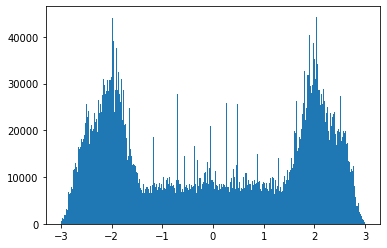

unique  68428
pt cut  68428
unique hits  71845
pt cut  71845


/Users/innocent/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


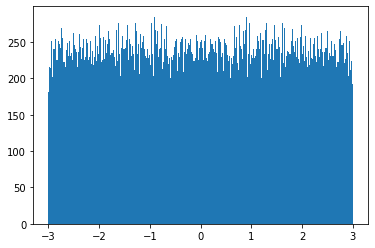

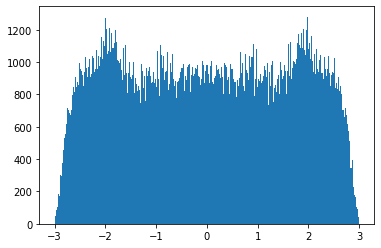

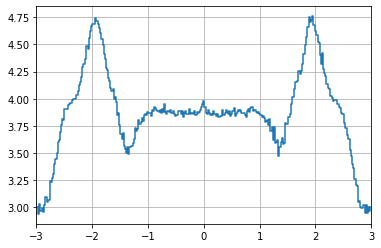

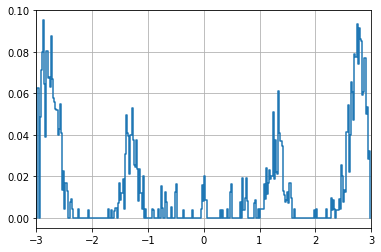

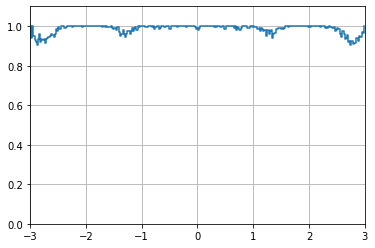

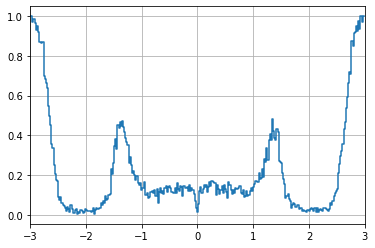

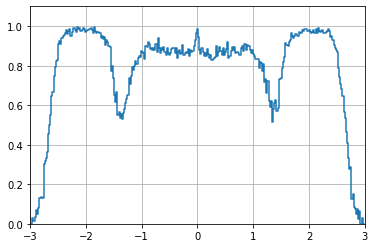

In [26]:
allComb = pd.concat([t12312,t12123,qall,trin,trout,trj,cpairs,jpairs],sort='True')
print ("all comb ",len(allComb))
allComb['etaTk'] =  allComb['eta1']/10000.  #  etaTk(allComb)
plt.hist(allComb['etaTk'],log=False, bins=300, range=[-3,3],weights=allComb['nhits'])
plt.show()
allComb.drop_duplicates(subset='trackID', keep='first', inplace=True)
print ("unique ",len(allComb))
allComb.query('pt1>600',inplace=True)
print ("pt cut ",len(allComb))

selHits = hits.drop_duplicates(subset='trackID', keep='first')
print ('unique hits ',len(selHits))
selHits.query('pt>600',inplace=True)
print ('pt cut ',len(selHits))
plt.hist(selHits['eta']/10000.,log=False, bins=300, range=[-3,3])
plt.show()

plt.hist(allComb['etaTk'],log=False, bins=300, range=[-3,3],weights=allComb['nhits'])
plt.show()
yv,xv = np.histogram(allComb['etaTk'],np.linspace(-3.,3.,300),weights=allComb['nhits']) 
y1,x1 = np.histogram(allComb['etaTk'],np.linspace(-3.,3.,300))
x = xv.copy()
x.resize(len(yv))
plt.step(x,yv/y1,where='post')
plt.xlim(-3.0, 3.0)
plt.grid(True)
#    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.legend(loc='upper right')
plt.show()

doub = np.less(allComb['nhits'],2.5)
yd,xd = np.histogram(allComb['etaTk'],np.linspace(-3.,3.,300),weights=1.*doub) 
plt.step(x,yd/y1,where='post')
plt.xlim(-3.0, 3.0)
plt.grid(True)
plt.show()

plt.step(x,1.-yd/y1,where='post')
plt.xlim(-3.0, 3.0)
plt.ylim(0.0, 1.1)
plt.grid(True)
plt.show()

tripl = np.less(allComb['nhits'],3.5)
yd,xd = np.histogram(allComb['etaTk'],np.linspace(-3.,3.,300),weights=1.*tripl) 
plt.step(x,yd/y1,where='post')
plt.xlim(-3.0, 3.0)
plt.grid(True)
plt.show()

plt.step(x,1.-yd/y1,where='post')
plt.xlim(-3.0, 3.0)
plt.ylim(0.0, 1.1)
plt.grid(True)
plt.show()
                    


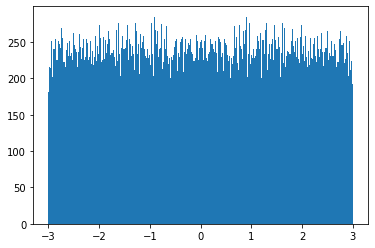

w/r/t hit


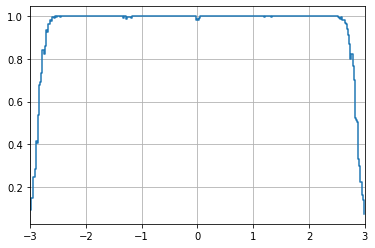

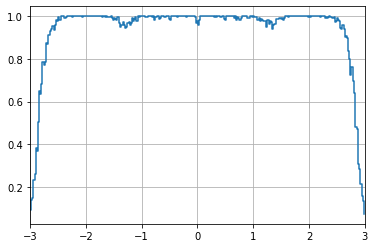

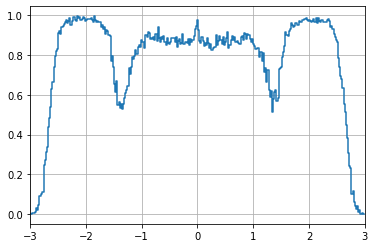

In [27]:
plt.hist(selHits['eta']/10000.,log=False, bins=300, range=[-3,3])
plt.show()

yh,xh=np.histogram(selHits['eta']/10000.,np.linspace(-3.,3.,300))

print("w/r/t hit")
yd,xd = np.histogram(allComb['etaTk'],np.linspace(-3.,3.,300)) 
plt.step(x,yd/yh,where='post')
plt.xlim(-3.0, 3.0)
plt.grid(True)
plt.show()

yd,xd = np.histogram(allComb['etaTk'],np.linspace(-3.,3.,300),weights=1.*(1.-doub)) 
plt.step(x,yd/yh,where='post')
plt.xlim(-3.0, 3.0)
plt.grid(True)
plt.show()

yd,xd = np.histogram(allComb['etaTk'],np.linspace(-3.,3.,300),weights=1.*(1.-tripl)) 
plt.step(x,yd/yh,where='post')
plt.xlim(-3.0, 3.0)
plt.grid(True)
plt.show()



188    1.173689
218    1.646516
392    1.631448
393    1.711987
394    1.726466
Name: phi3, dtype: float64
188    3.1
218    3.1
392    3.1
393    3.1
394    3.1
Name: phi3, dtype: float64


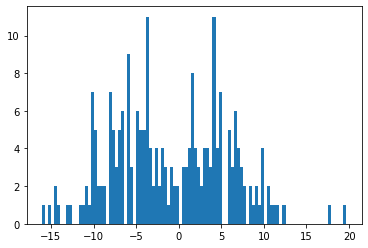

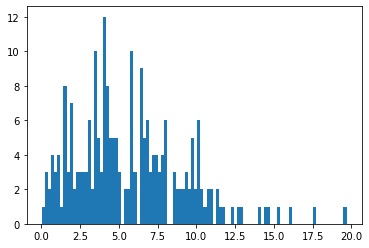

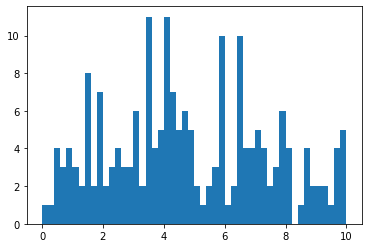

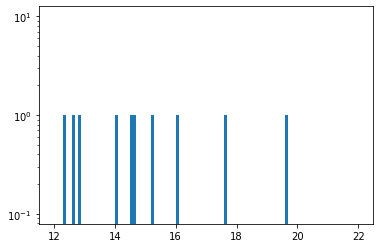

/Users/innocent/Library/Python/3.7/lib/python/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


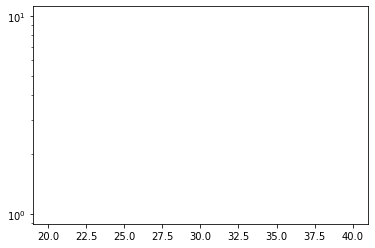

In [28]:
# triplet + hole@0
tri0 = pd.concat([t0231,t0212])
tri = tri0[tri0['pt3']>600];
p3 = 6*tri['phi3'].where(tri['phi3']>0,tri['phi3']+6.2831)/3.14157
p3 = p3.mod(2)
print (p3.head())
r4 = p3.copy()
r4.where(p3>=1,2.8,inplace=True)
r4.where(p3<1,3.1,inplace=True)
print (r4.head())
hole = zAtR(t1230[t1230['pt3']>600],r4)
plt.hist(hole[abs(hole)<40],log=False, bins=100)
plt.show()
plt.hist(abs(hole[abs(hole)<40]),log=False, bins=100)
plt.show()
plt.hist(abs(hole[abs(hole)<10]),log=False, bins=50, range=[0,10])
plt.show()
plt.hist(abs(hole[abs(hole)<30]),log=True, bins=100, range=[12,22])
plt.show()
plt.hist(abs(hole[abs(hole)<40]),log=True, bins=100, range=[20,40])
plt.show()



0    1.373998
5    1.603625
6    1.089635
7    0.102362
9    0.790370
Name: phi3, dtype: float64
0    16.146
5    16.146
6    16.146
7    15.815
9    15.815
Name: phi3, dtype: float64


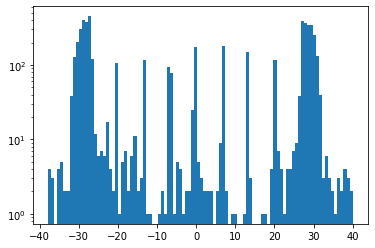

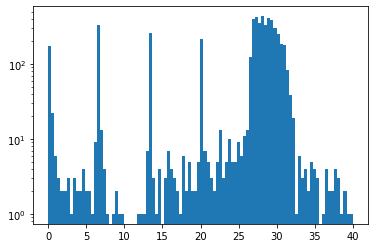

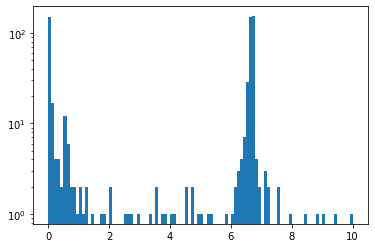

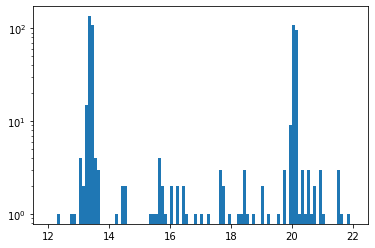

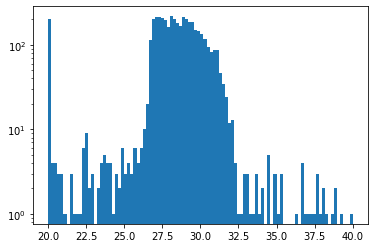

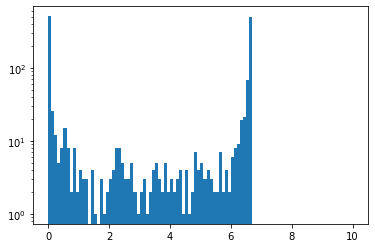

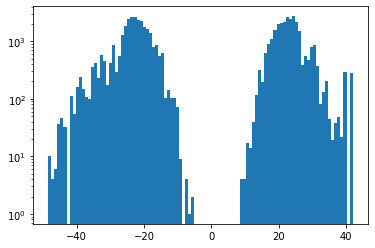

In [29]:
# triplet + hole@4
tri = t1230[t1230['pt3']>600];
p3 = 32*tri['phi3'].where(tri['phi3']>0,tri['phi3']+6.2831)/3.14157
p3 = p3.mod(2)
print (p3.head())
r4 = p3.copy()
r4.where(p3>1,15.815,inplace=True)
r4.where(p3<1,16.146,inplace=True)
print (r4.head())
hole = zAtR(t1230[t1230['pt3']>600],r4)
plt.hist(hole[abs(hole)<40],log=True, bins=100)
plt.show()
plt.hist(abs(hole[abs(hole)<40]),log=True, bins=100)
plt.show()
plt.hist(abs(hole[abs(hole)<10]),log=True, bins=100, range=[0,10])
plt.show()
plt.hist(abs(hole[abs(hole)<30]),log=True, bins=100, range=[12,22])
plt.show()
plt.hist(abs(hole[abs(hole)<40]),log=True, bins=100, range=[20,40])
plt.show()
ab = abs(hole)
ab = ab - 6.7*ab.floordiv(6.7)
plt.hist(ab[abs(hole)<26.8],log=True, bins=100, range=[0,10])
plt.show()
penta = zAtR(t12123[t12123['pt3']>600],6.5)
plt.hist(penta[abs(penta)<50],log=True, bins=100)
plt.show()

In [30]:
def plotTriplets(quad,mpt,kq) :
    
  print (" ")
  print ("New QUAD",kq)
  print (" ")
    
    
  d1 = (quad['r1']*quad['z2']-quad['z1']*quad['r2'])/(quad['r1']-quad['r2'])
  d2 = (quad['r2']*quad['z3']-quad['z2']*quad['r3'])/(quad['r2']-quad['r3'])
  d3 = (quad['r3']*quad['z4']-quad['z3']*quad['r4'])/(quad['r3']-quad['r4'])
  
  z0cut = np.logical_and(abs(d1)<10.,np.logical_and(abs(d2)<10.,abs(d3)<10.))

  quadc = quad[np.logical_and(z0cut,quad['pt1']>mpt)]

#  print 'dpt'
#  plt.hist(quad['pt1']-quad['pt2'],log=True, bins=100)
#  plt.show()
#  plt.hist(quad['pt2']-quad['pt3'],log=True, bins=100)
#  plt.show()
#  plt.hist(quad['pt3']-quad['pt4'],log=True, bins=100)
#  plt.show()


  print ('delta123', len(quadc))
  
#dt,dtn = ml(t123['tpt'],t123['tpz'],t123['tpt2'],t123['tpz2'])
#plt.hist(dt[dt<0.1], log=True, bins=100)
#plt.show()
#plt.hist(dtn[dtn<0.1], log=True, bins=100)
#plt.show()

    
  thcut = alignRZ(quadc,'r',0.6,True)
  pzcut = alignRZ(quadc,'phi',1.0,True)
  thcut2 = alignRPZ(quadc,'r',True)
  pzcut2 = alignRPZ(quadc,'phi',True)

  dc = dca(quadc,True)
  curv1 = dca(quadc,True,True)
  field = curv1-1/(0.087*quadc['pt1'])
  print ('field')
  plt.hist(field[abs(field)<5],log=True, bins=100)
  plt.show()
  print ('thcut,pzcut,dcacut',len(thcut))
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.3],log=True, bins=100)
  plt.show()

  print ('thcut2,pzcut2',len(thcut2))
  plt.hist(thcut2[abs(thcut2)<0.6],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.2],log=True, bins=100)
  plt.show()
 
  print ('delta234')

  thcut = alignRZ(quadc,'r',0.6,False)
  pzcut = alignRZ(quadc,'phi',1.0,False)
  thcut2 = alignRPZ(quadc,'r',False)
  pzcut2 = alignRPZ(quadc,'phi',False)
  dc = dca(quadc,False)
  curv2 = dca(quadc,False,True)
  field =curv2 -1/(0.087*quadc['pt1'])
  print ('field')
  plt.hist(field[abs(field)<5],log=True, bins=100)
  plt.show()
  print ('delta curv')
  dcu = curv2-curv1
  plt.hist(dcu[abs(dcu)<0.15],log=True, bins=100)
  plt.show()  
  print ('thcut,pzcut,dcacut',len(thcut))
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.3],log=True, bins=100)
  plt.show()

    
  print ('thcut2,pzcut2',len(thcut2))
  plt.hist(thcut2[abs(thcut2)<0.6],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.2],log=True, bins=100)
  plt.show()


In [31]:
kq=0
def plotDoublets(quad,mpt,kq) :
  quadc = quad[quad['pt1']>mpt]

  maxc = 1000./(mpt*87.78)

  print (" ")
  print ("New QUAD"),kq
  print (" ")
    
  print ('dphi')
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[abs(d1)<.1], bins=100,log=True)
  plt.show()
  d2 = quadc['phi3']-quadc['phi2']
  plt.hist(d2[abs(d2)<.1], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[abs(d3)<.1], bins=100,log=True)
  plt.show()

  pcut = np.logical_and(abs(d1)<0.05,np.logical_and(abs(d2)<0.05,abs(d3)<0.05))


  print ('dphiNor')
    
  pc = phicut(quadc['r1'],quadc['r2'],maxc)
  d1 = (quadc['phi2']-quadc['phi1'])/pc
  plt.hist(d1[abs(d1)<2.], bins=100,log=True)
  plt.show()
  pc = phicut(quadc['r2'],quadc['r3'],maxc)
  d2 = (quadc['phi3']-quadc['phi2'])/pc
  plt.hist(d2[abs(d2)<2.], bins=100,log=True)
  plt.show()
  pc = phicut(quadc['r3'],quadc['r4'],maxc)
  d3 = (quadc['phi4']-quadc['phi3'])/pc
  plt.hist(d3[abs(d3)<2.], bins=100,log=True)
  plt.show()


  print ('zinner')
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print ('dz')
  d1 = quadc['z2']-quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z3']-quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z4']-quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print ('z0')
  d1 = (quadc['r1']*quadc['z2']-quadc['z1']*quadc['r2'])/(quadc['r1']-quadc['r2'])
  plt.hist(d1[np.logical_and(pcut,abs(d1)<50)], bins=100,log=True)
  plt.show()
  d2 = (quadc['r2']*quadc['z3']-quadc['z2']*quadc['r3'])/(quadc['r2']-quadc['r3'])
  plt.hist(d2[np.logical_and(pcut,abs(d2)<50)], bins=100,log=True)
  plt.show()
  d3 = (quadc['r3']*quadc['z4']-quadc['z3']*quadc['r4'])/(quadc['r3']-quadc['r4'])
  plt.hist(d3[np.logical_and(pcut,abs(d3)<50)], bins=100,log=True)
  plt.show()
  

  pcut = np.logical_and(abs(d1)<10.,np.logical_and(abs(d2)<10.,abs(d3)<10.))


  print ('dr')
  d1 = quadc['r2']-quadc['r1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<20)], bins=100,log=True)
  plt.show()
  d2 = quadc['r3']-quadc['r2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<20)], bins=100,log=True)
  plt.show()
  d3 = quadc['r4']-quadc['r3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<20)], bins=100,log=True)
  plt.show()

  print ('dphi zcut')
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<.1)], bins=100,log=True)
  plt.show()
  d2 = quadc['phi3']-quadc['phi2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<.1)], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<.1)], bins=100,log=True)
  plt.show()

  print ('zinner zcut')
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print ('module')
  d1 = quadc['det1']
  plt.hist(d1[pcut], range=[0,96], bins=96, log=False)
  plt.show()
  d2 = quadc['det2']
  plt.hist(d2[pcut], range=[0,2000], bins=2000, log=False)
  plt.show()
  d3 = quadc['det3']
  plt.hist(d3[pcut], range=[0,2000], bins=2000, log=False)
  plt.show()



  norm = 1./8.
  print ('dysize')
  d1 = (quadc['ys2']-quadc['ys1'])*norm
  c = np.logical_and(quadc['ys2']>0,quadc['ys1']>0)
  plt.hist(d1[np.logical_and(pcut,c)], range=[-8,8],bins=32,log=True)
  plt.show()
  c = np.logical_and(quadc['ys2']>0,quadc['ys3']>0)
  d2 = (quadc['ys3']-quadc['ys2'])*norm
  plt.hist(d2[np.logical_and(pcut,c)], range=[-6,6],bins=26,log=True)
  plt.show()
  c = np.logical_and(quadc['ys4']>0,quadc['ys3']>0)
  d3 = (quadc['ys4']-quadc['ys3'])*norm
  plt.hist(d3[np.logical_and(pcut,c)], range=[-6,6],bins=26,log=True)
  plt.show()

    
  print ('ysize')
  d1 = quadc['ys1']*norm
  plt.hist(d1[pcut], bins=30,range=[0,30],log=True)
  plt.show()
  d2 = quadc['ys2']*norm
  plt.hist(d2[pcut], bins=30,range=[0,30],log=True)
  plt.show()
  d3 = quadc['ys3']*norm
  plt.hist(d3[pcut], bins=30,range=[0,30],log=True)
  plt.show()
 
  print ('ys-pred')
  th = 0.0285
  ptc = 0.015
  fac = th/ptc
  d1 = fac*(quadc['z1']-quadc['z2'])/(quadc['r1']-quadc['r2'])
  d1 = quadc['ys1']*norm - abs(d1)
  plt.hist(d1[np.logical_and(pcut,quadc['ys1']>0)], range=[-8,8],bins=32,log=True)
  plt.show()
  d2 = fac*(quadc['z3']-quadc['z2'])/(quadc['r3']-quadc['r2'])
  d2 = quadc['ys2']*norm - abs(d2)
  plt.hist(d2[np.logical_and(pcut,quadc['ys2']>0)], range=[-8,8],bins=32,log=True)
  plt.show()
  d3 = fac*(quadc['z3']-quadc['z4'])/(quadc['r3']-quadc['r4'])
  d3 = quadc['ys3']*norm - abs(d3)
  plt.hist(d3[np.logical_and(pcut,quadc['ys3']>0)], range=[-8,8],bins=32,log=True)
  plt.show()

    

In [32]:
doTriplets = True
doDoublets = True

 
New QUAD 0
 
delta123 41216
field


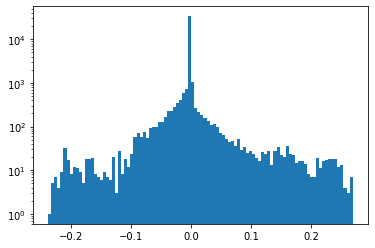

thcut,pzcut,dcacut 41216


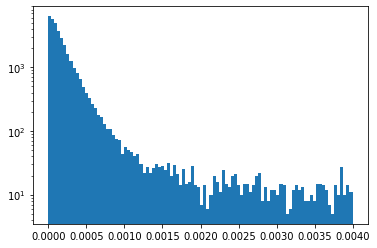

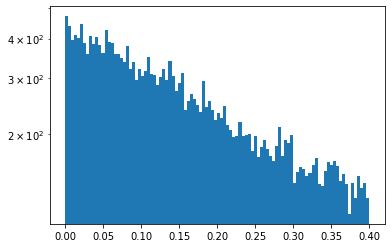

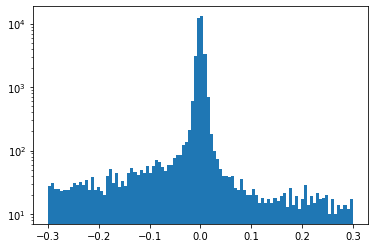

thcut2,pzcut2 41216


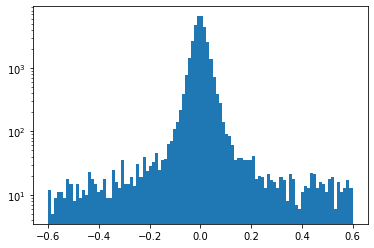

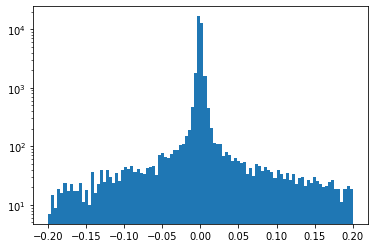

delta234
field


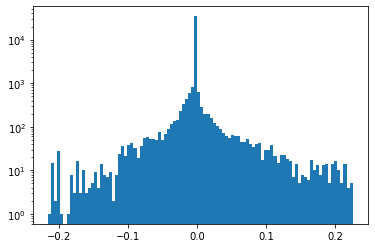

delta curv


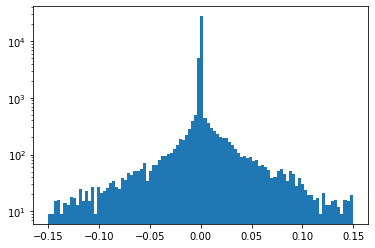

thcut,pzcut,dcacut 41216


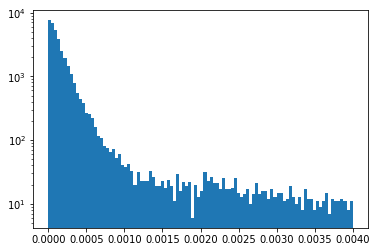

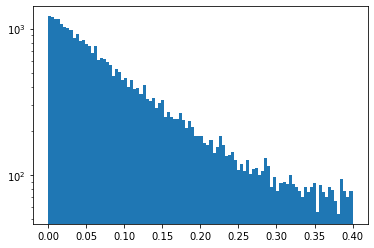

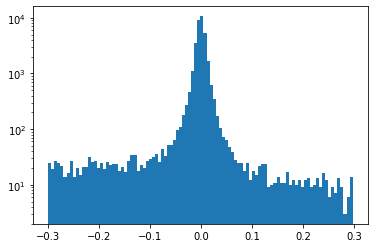

thcut2,pzcut2 41216


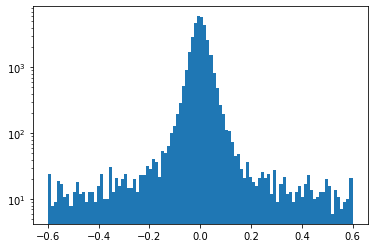

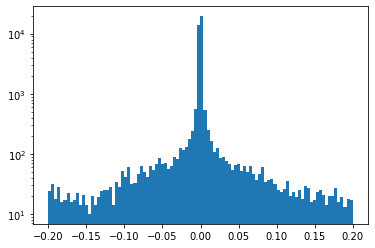

 
New QUAD 1
 
delta123 8897
field


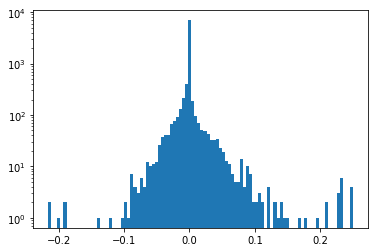

thcut,pzcut,dcacut 8897


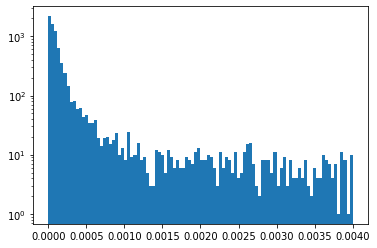

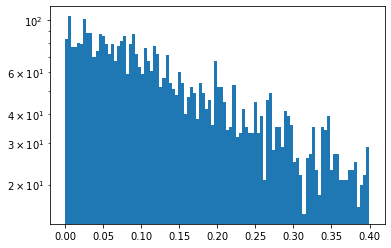

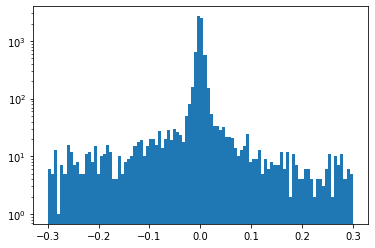

thcut2,pzcut2 8897


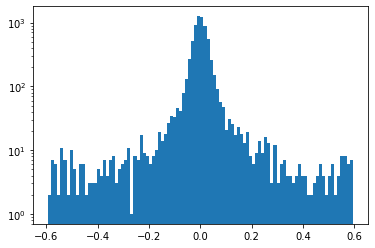

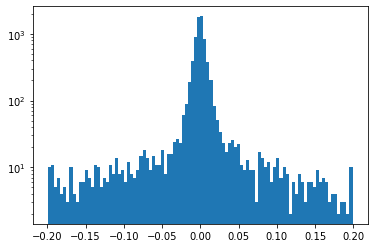

delta234
field


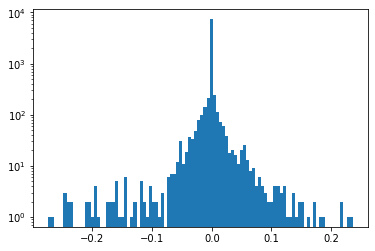

delta curv


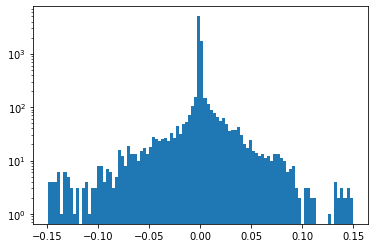

thcut,pzcut,dcacut 8897


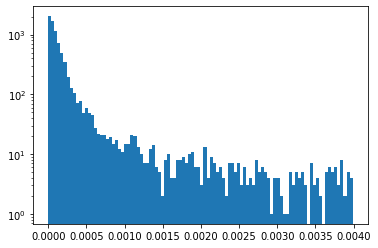

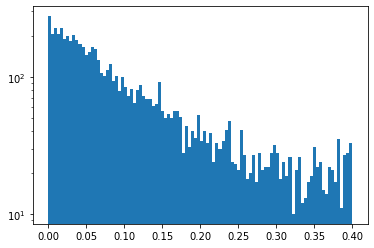

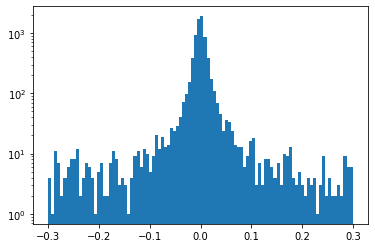

thcut2,pzcut2 8897


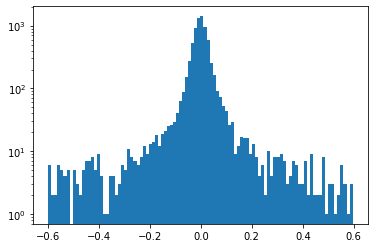

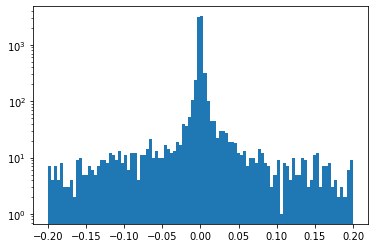

 
New QUAD 2
 
delta123 33037
field


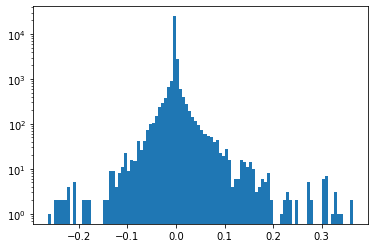

thcut,pzcut,dcacut 33037


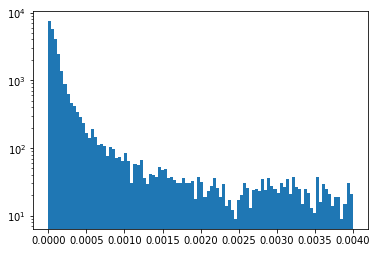

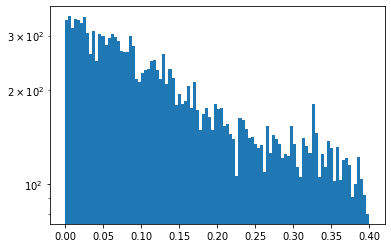

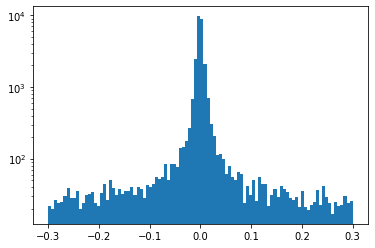

thcut2,pzcut2 33037


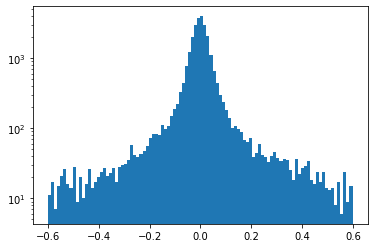

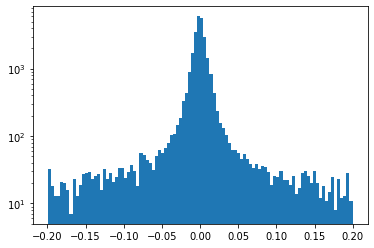

delta234
field


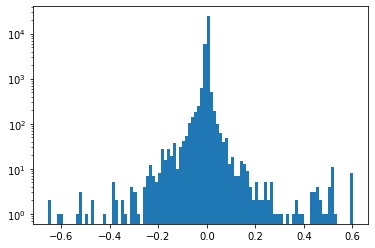

delta curv


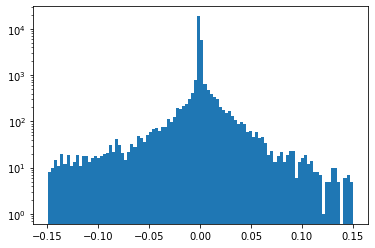

thcut,pzcut,dcacut 33037


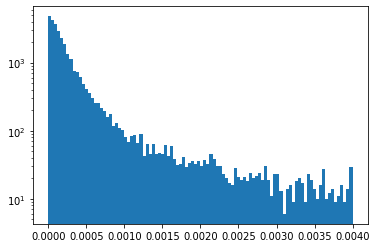

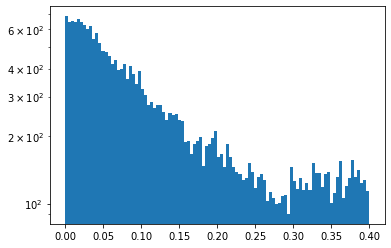

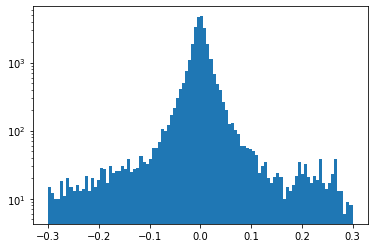

thcut2,pzcut2 33037


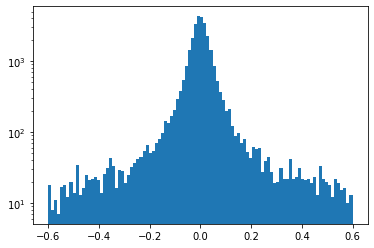

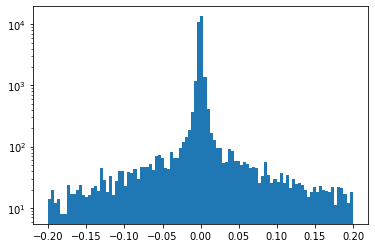

 
New QUAD 3
 
delta123 96883
field


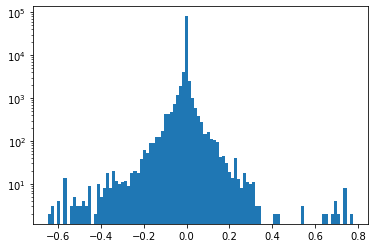

thcut,pzcut,dcacut 96883


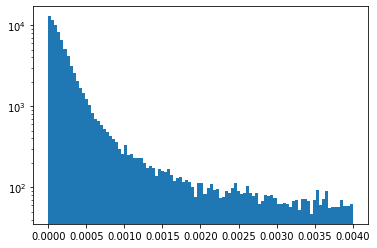

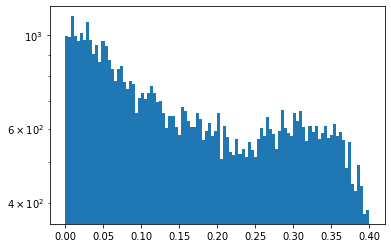

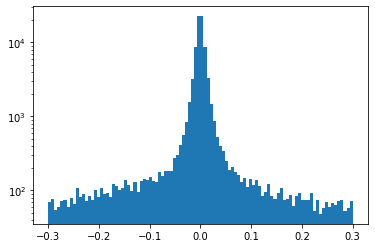

thcut2,pzcut2 96883


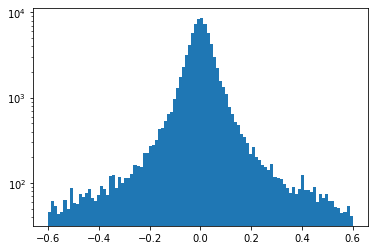

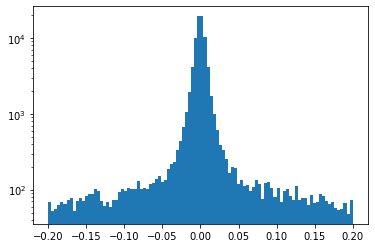

delta234
field


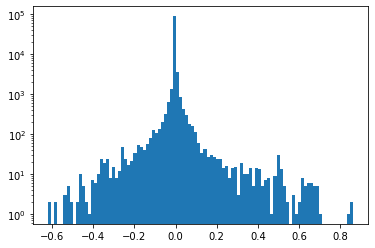

delta curv


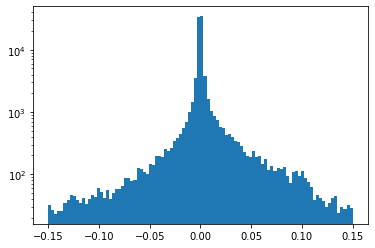

thcut,pzcut,dcacut 96883


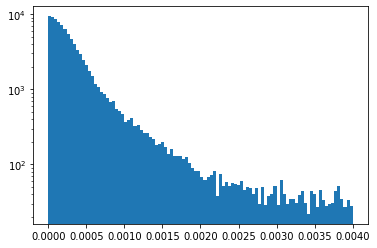

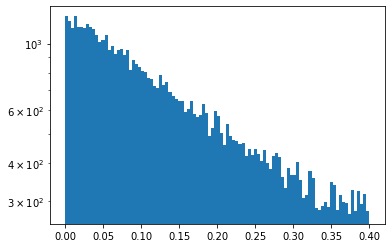

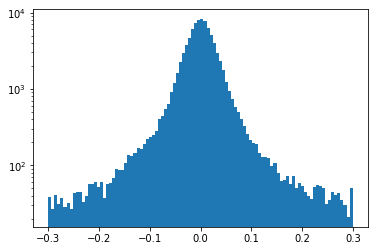

thcut2,pzcut2 96883


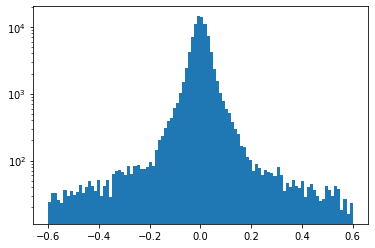

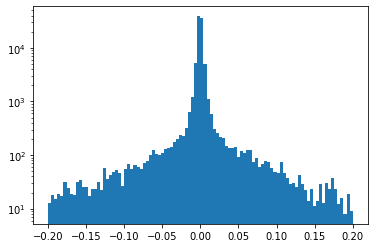

In [33]:
kq=0
if (doTriplets) :
  for quad in [t1234,t1231,t1212,t1123] :
    plotTriplets(quad,600, kq)
    kq+=1

 
New QUAD
 
dphi


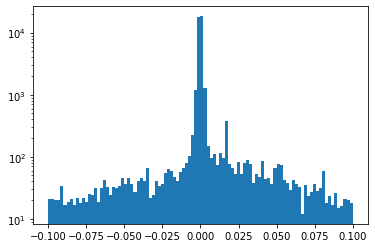

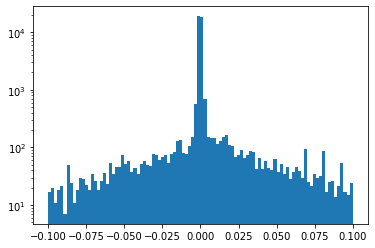

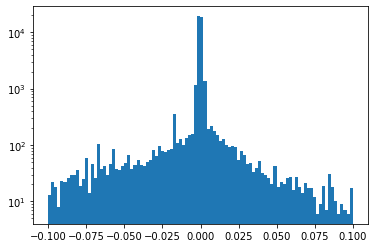

dphiNor


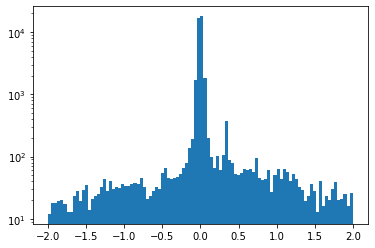

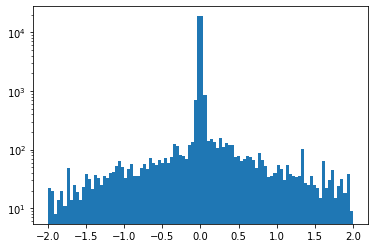

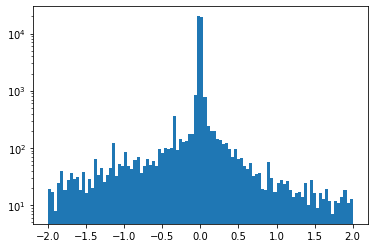

zinner


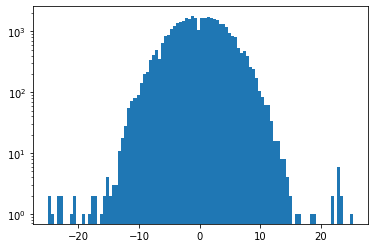

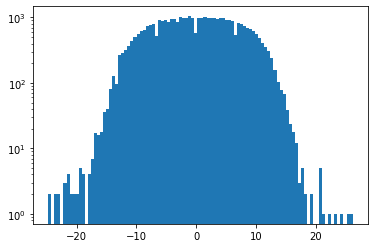

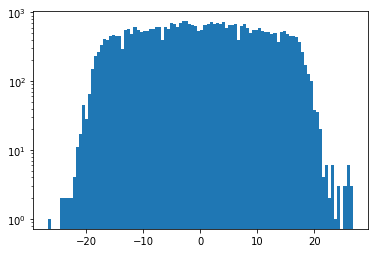

dz


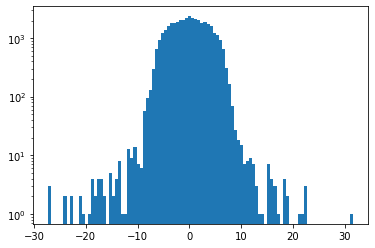

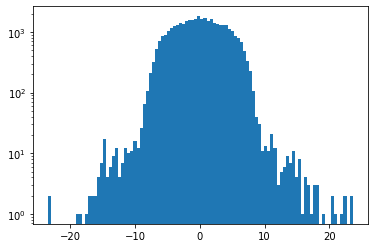

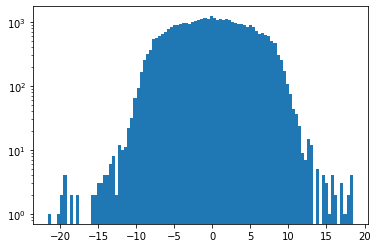

z0


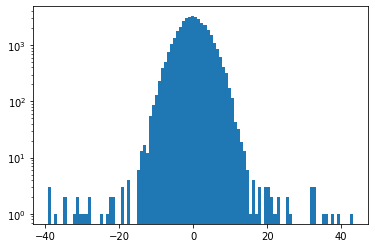

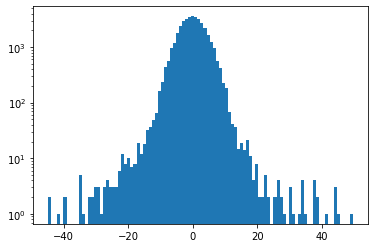

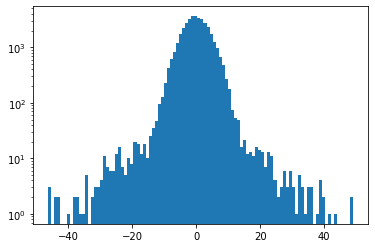

dr


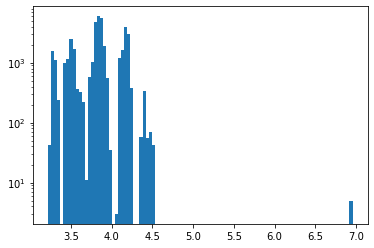

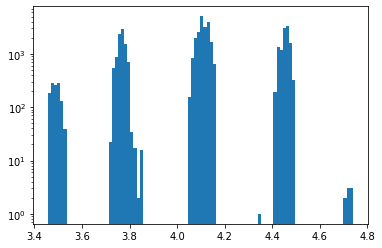

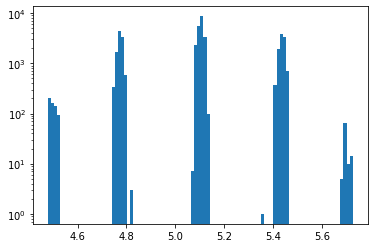

dphi zcut


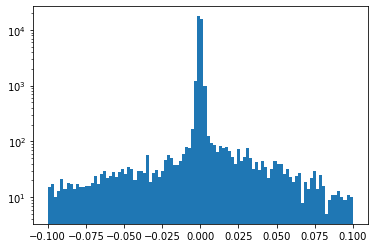

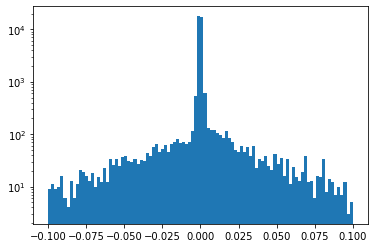

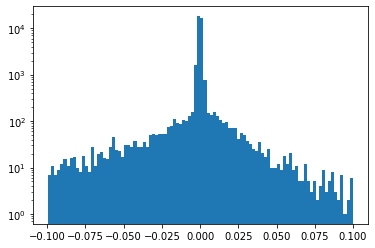

zinner zcut


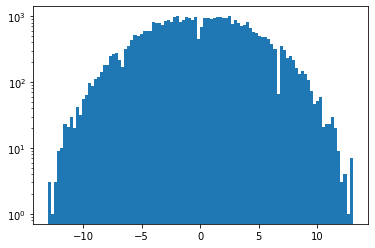

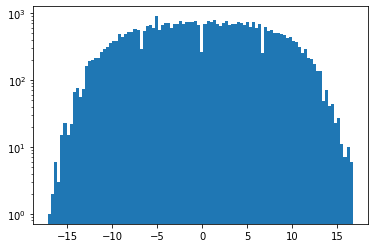

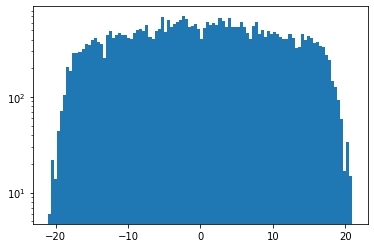

module


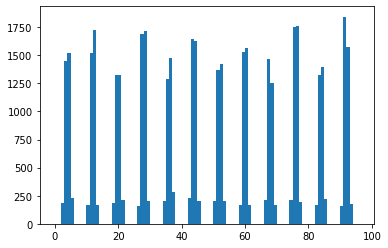

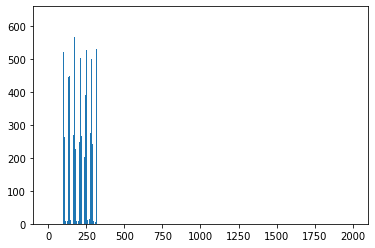

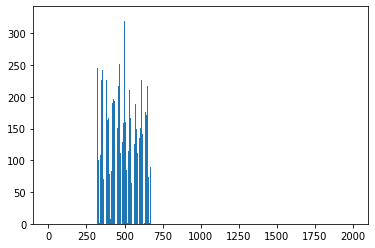

dysize


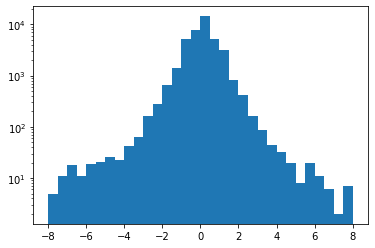

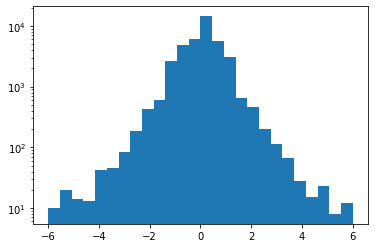

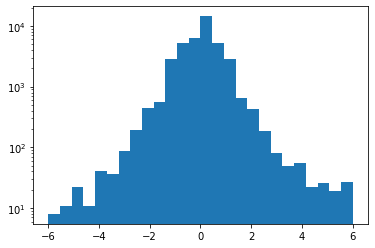

ysize


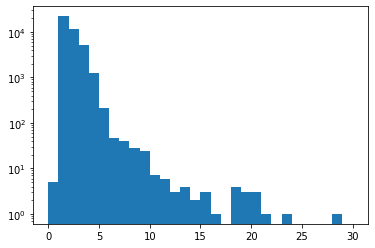

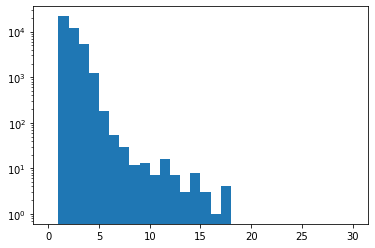

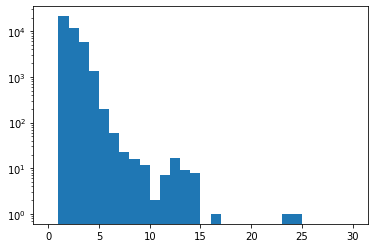

ys-pred


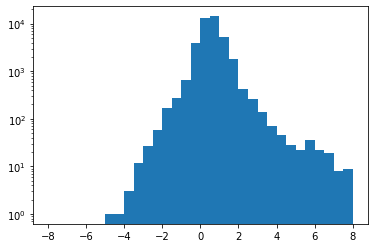

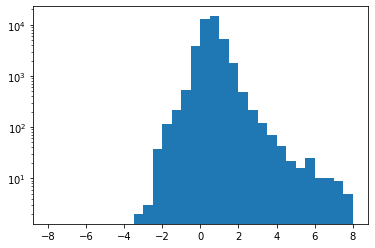

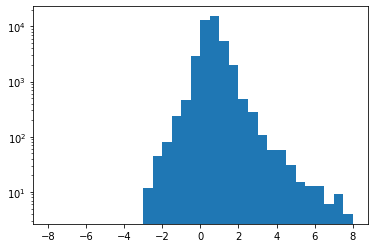

 
New QUAD
 
dphi


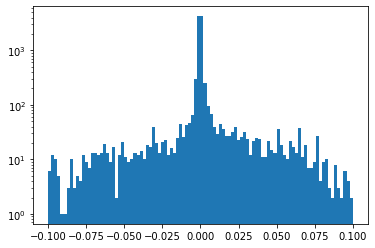

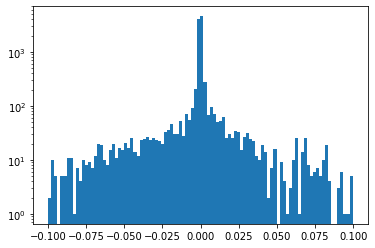

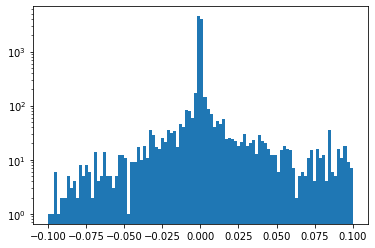

dphiNor


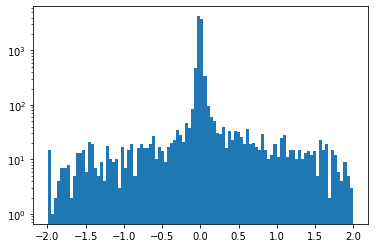

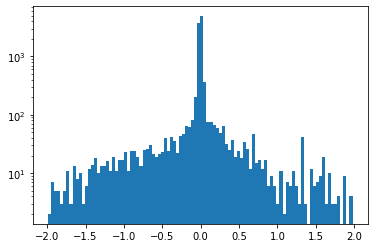

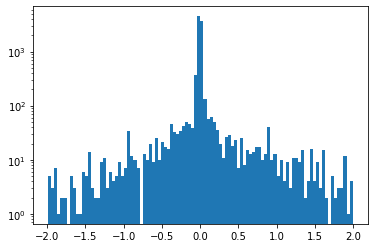

zinner


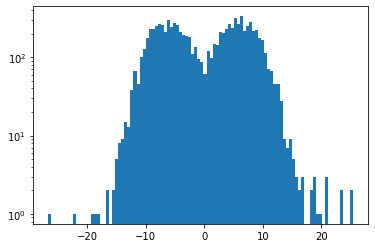

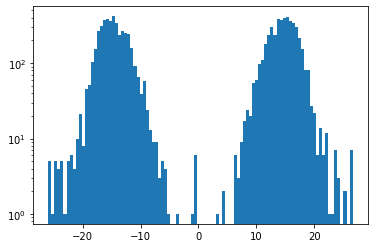

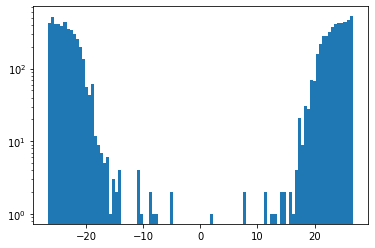

dz


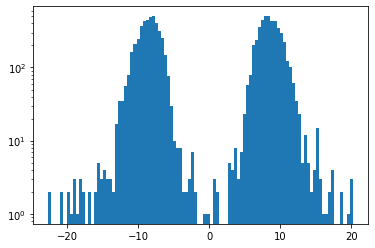

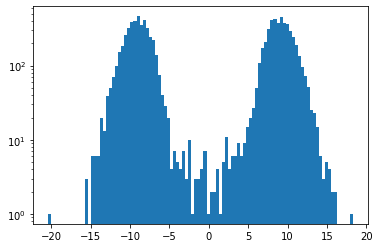

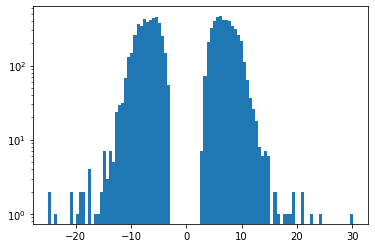

z0


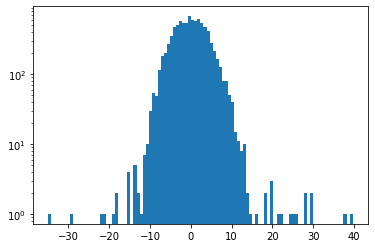

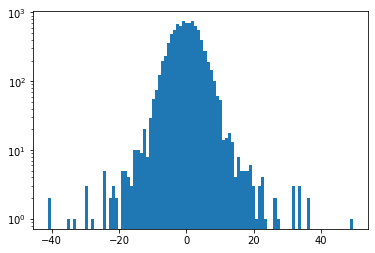

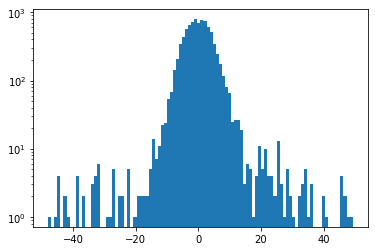

dr


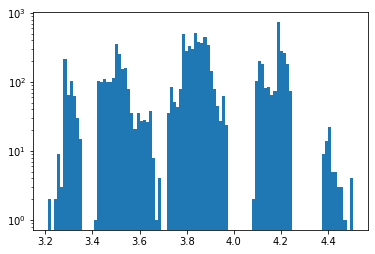

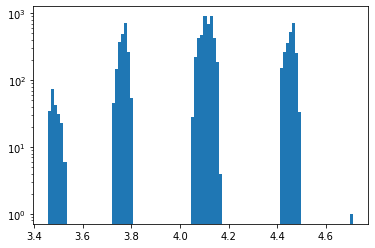

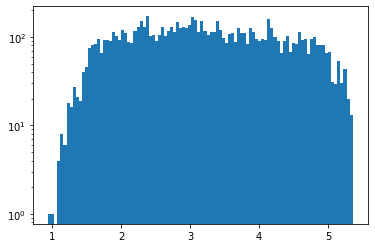

dphi zcut


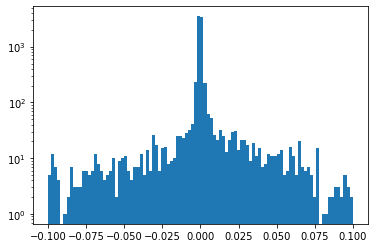

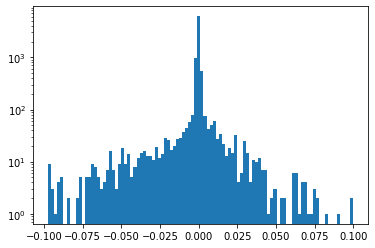

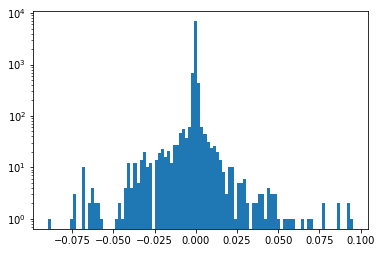

zinner zcut


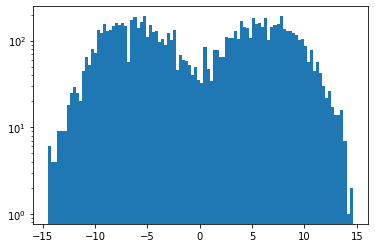

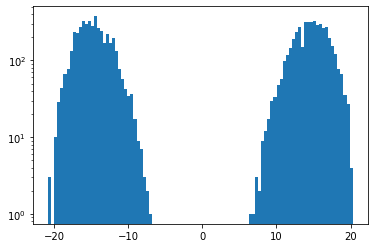

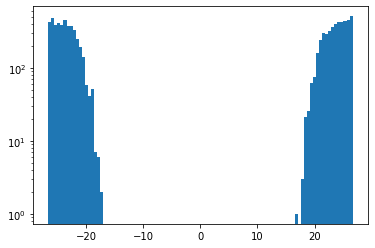

module


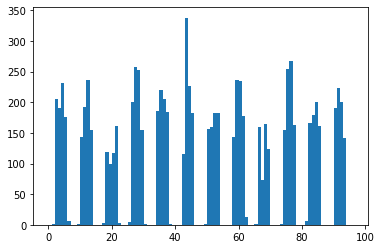

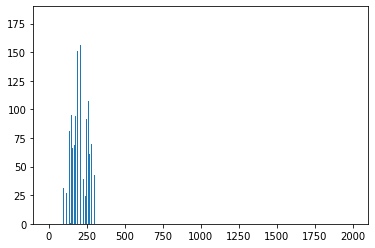

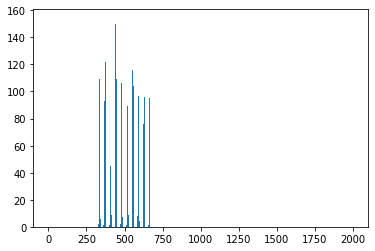

dysize


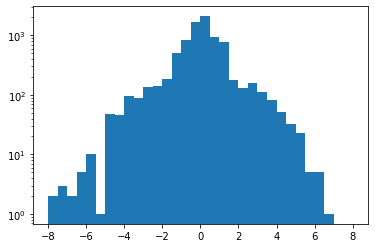

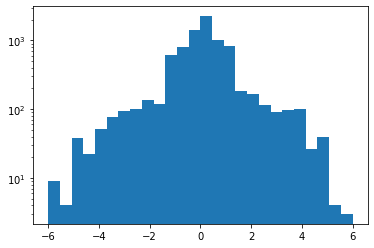

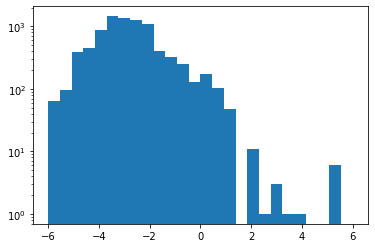

ysize


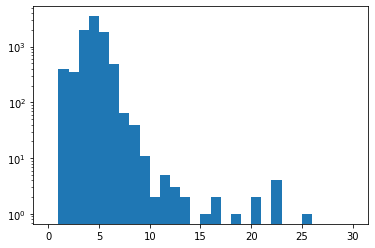

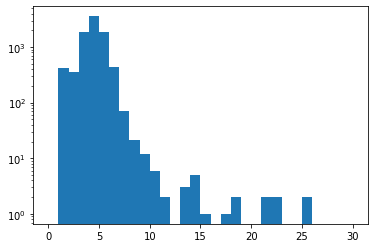

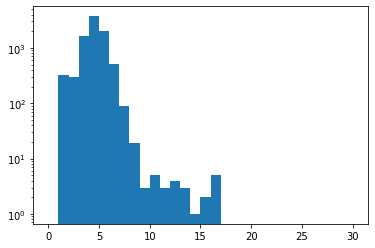

ys-pred


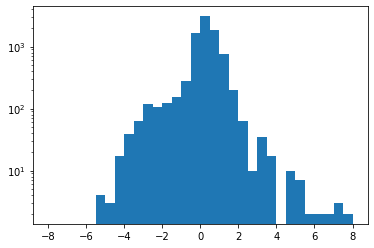

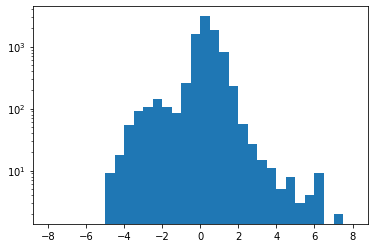

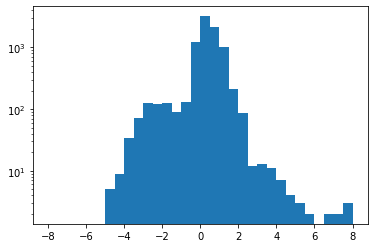

 
New QUAD
 
dphi


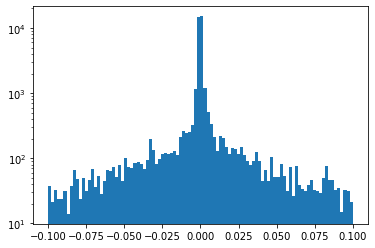

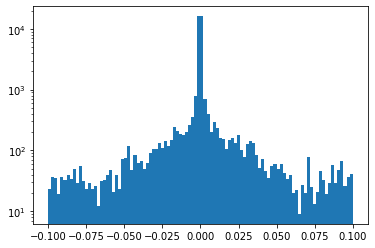

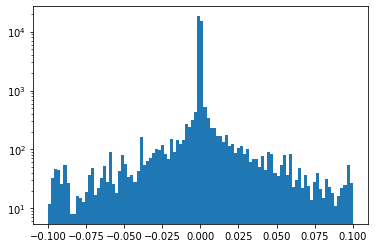

dphiNor


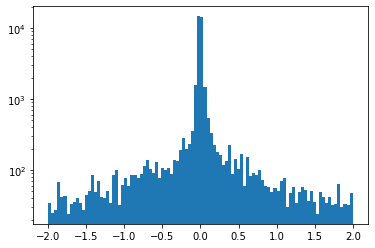

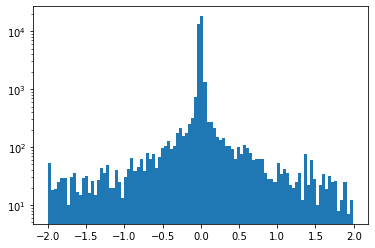

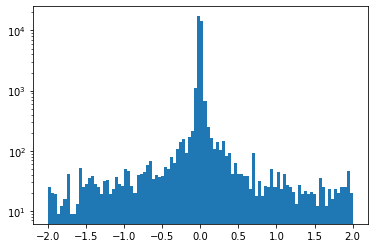

zinner


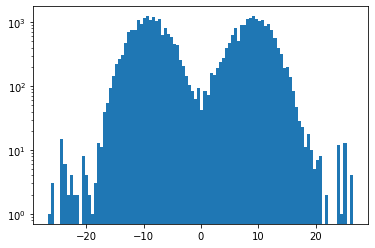

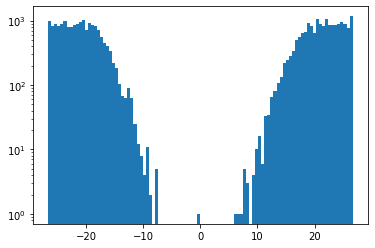

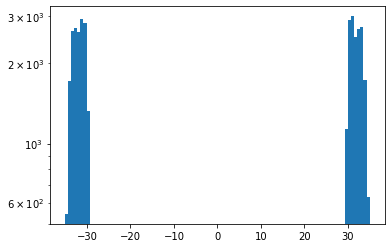

dz


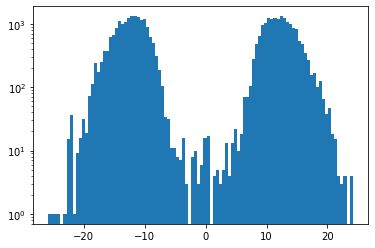

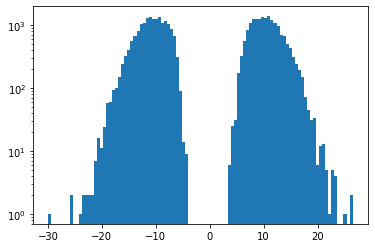

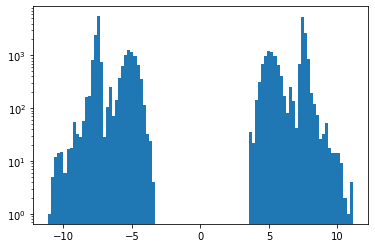

z0


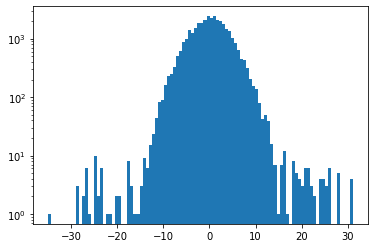

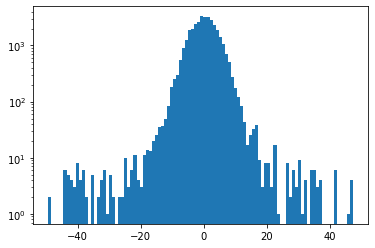

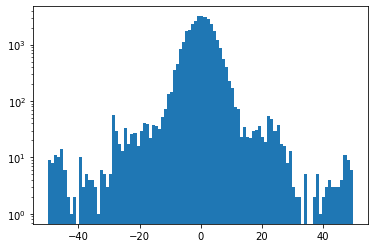

dr


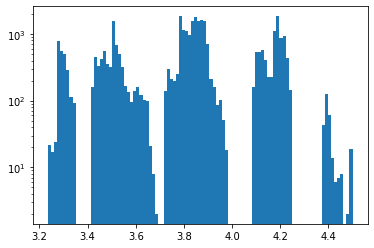

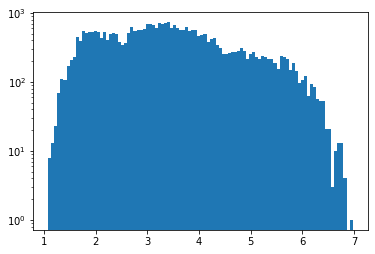

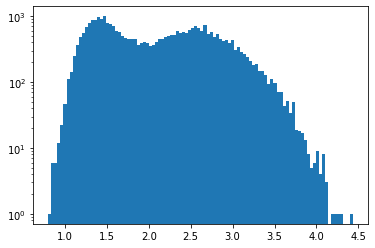

dphi zcut


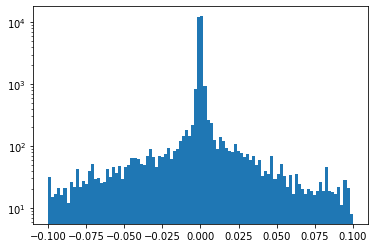

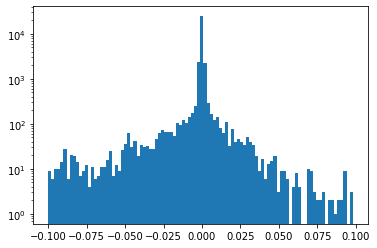

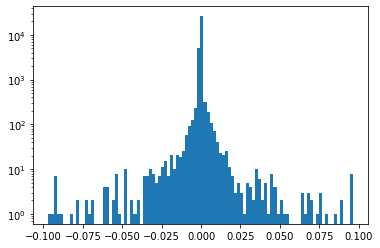

zinner zcut


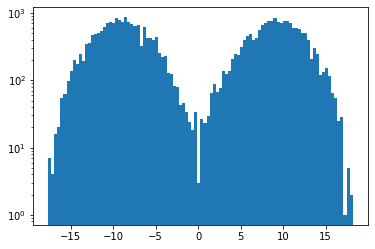

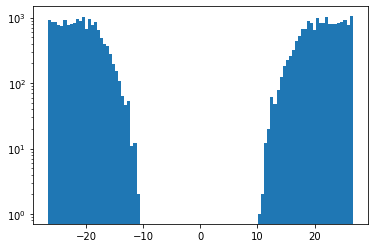

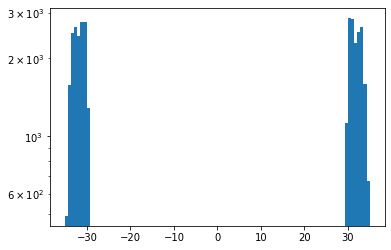

module


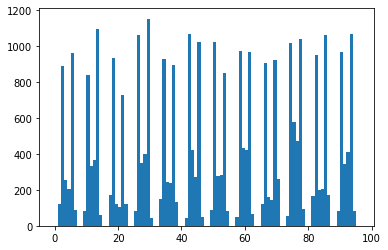

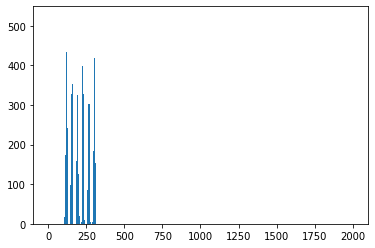

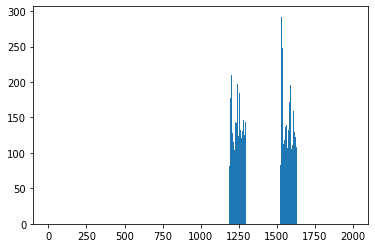

dysize


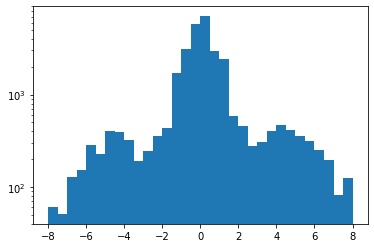

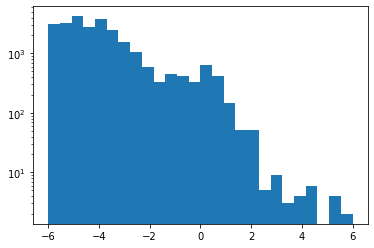

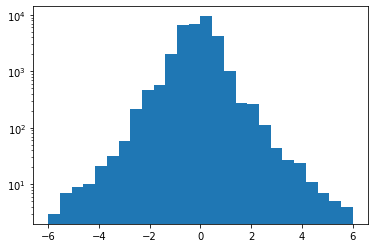

ysize


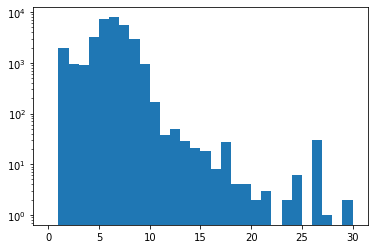

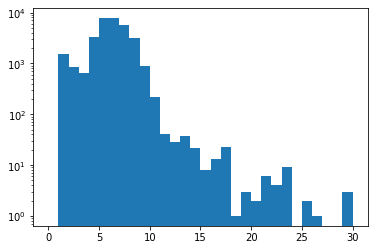

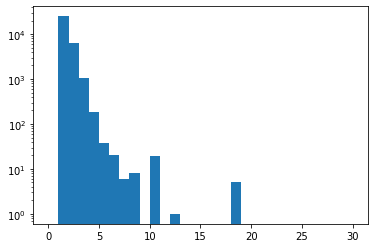

ys-pred


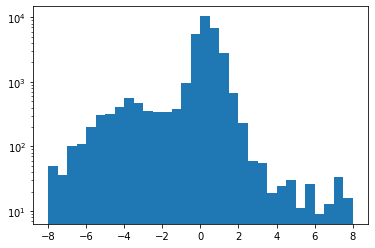

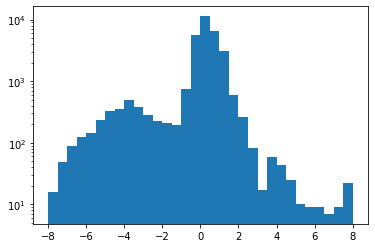

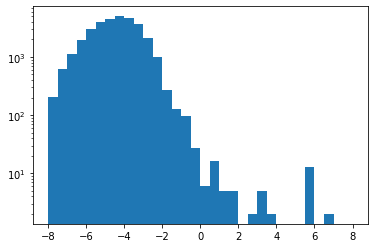

 
New QUAD
 
dphi


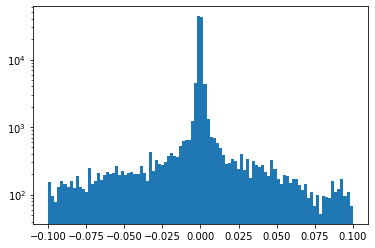

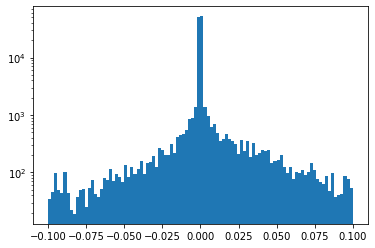

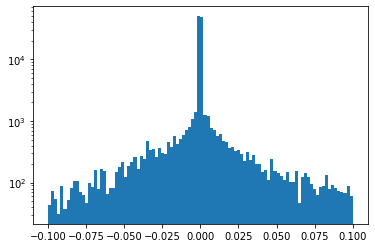

dphiNor


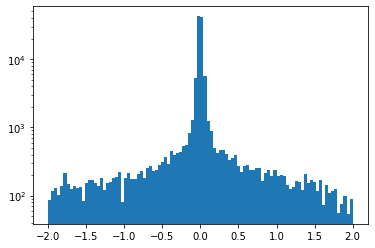

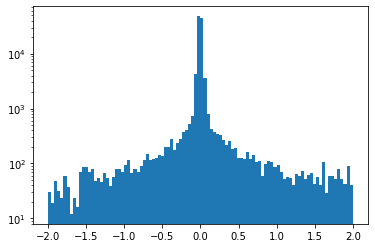

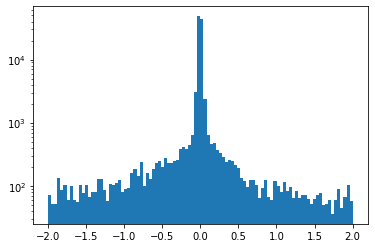

zinner


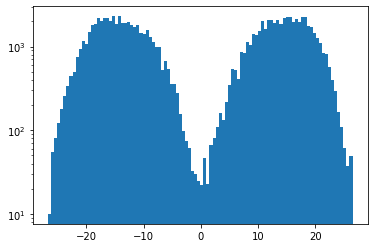

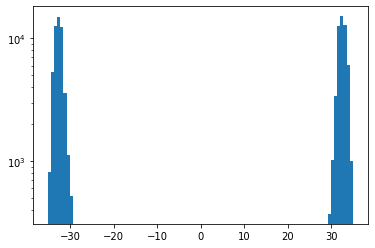

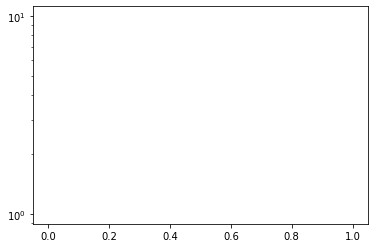

dz


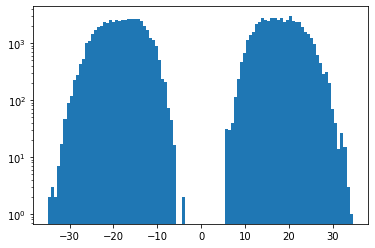

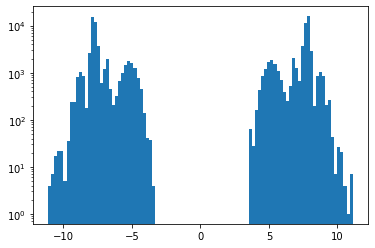

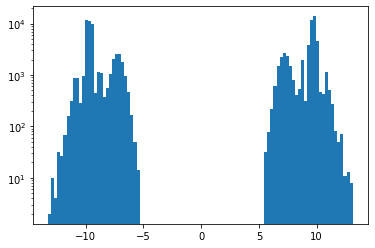

z0


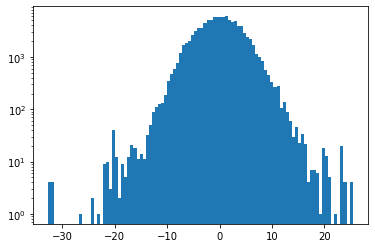

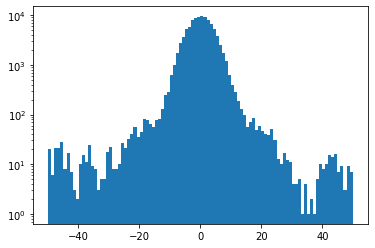

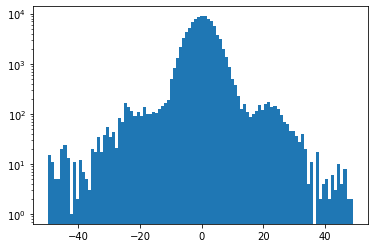

dr


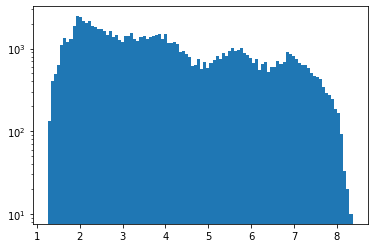

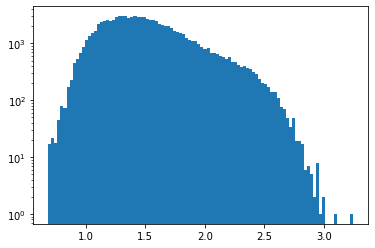

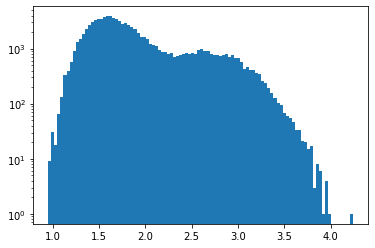

dphi zcut


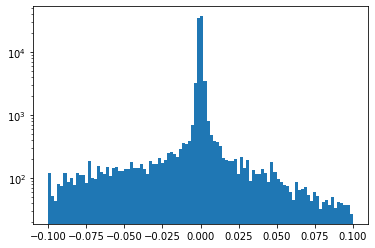

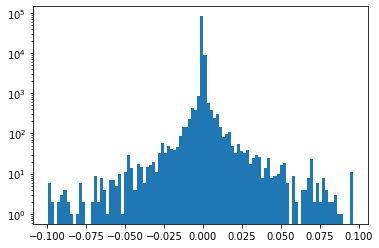

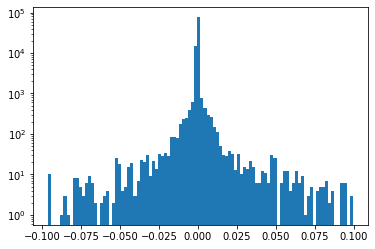

zinner zcut


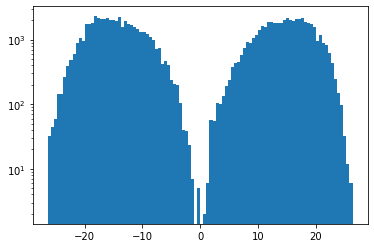

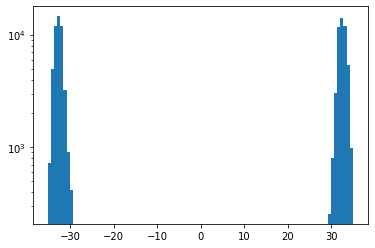

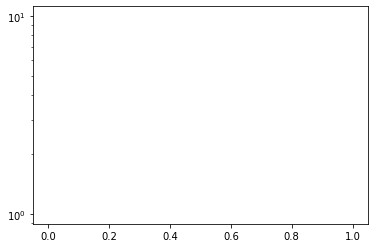

module


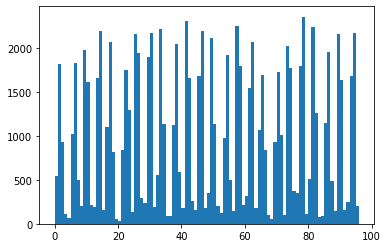

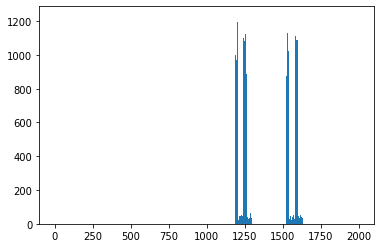

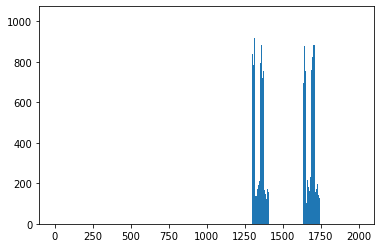

dysize


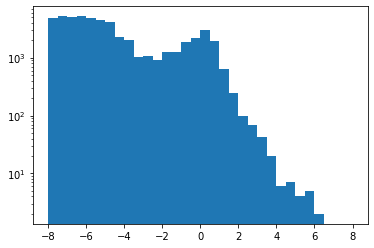

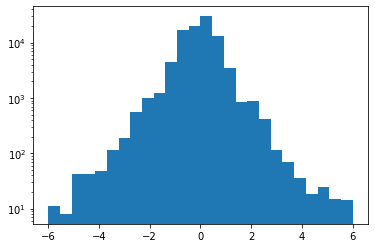

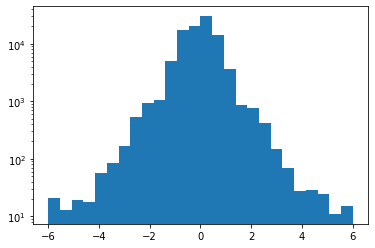

ysize


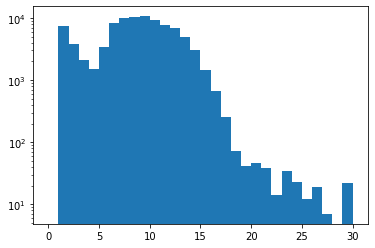

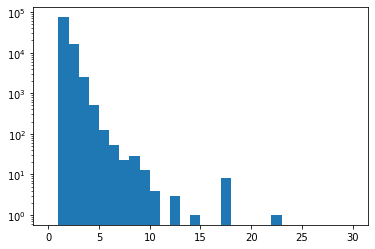

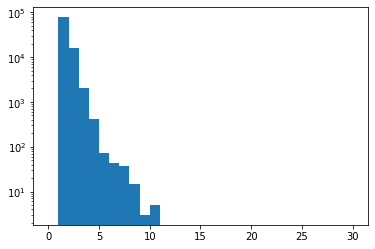

ys-pred


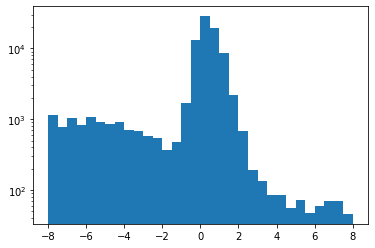

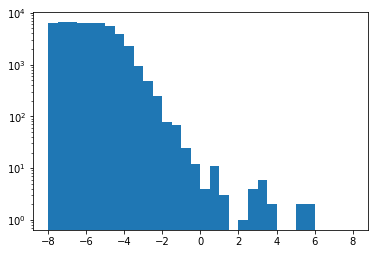

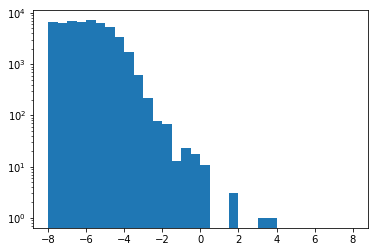

In [34]:
kq=0
if (doDoublets) :
  for quad in [t1234,t1231,t1212,t1123] :
    plotDoublets(quad,500,kq)
    kq+=1

In [35]:
def plotPairs(quad,mpt,kp) :
  quadc = quad[quad['pt1']>mpt]

  maxc = 1000./(mpt*87.78)

  print (" ")
  print ("NEW PAIR",kp, quad['seq1'][0], quad['seq2'][0])
  print (" ") 
    
  print ('dphi')
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[abs(d1)<.1], bins=100,log=True)
  plt.grid()
  plt.show()

  pcut = abs(d1)<0.06


  print ('dphiNor')
    
  pc = phicut(quadc['r1'],quadc['r2'],maxc)
  d1 = (quadc['phi2']-quadc['phi1'])/pc
  plt.hist(d1[abs(d1)<2.5], bins=100,log=True)
  plt.grid()
  plt.show()


  print ('zinner')
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()

  print ('dz')
  d1 = quadc['z2']-quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()

  print ('z0')
  d1 = (quadc['r1']*quadc['z2']-quadc['z1']*quadc['r2'])/(quadc['r1']-quadc['r2'])
  plt.hist(d1[np.logical_and(pcut,abs(d1)<50)], bins=100,log=True)
  plt.grid()
  plt.show()
  
  res=40./10000.
  err1 = quadc['r2'].copy()
  err1.where(quadc['seq1']<5,quadc['z2'], inplace=True)
  err2 = quadc['r1'].copy()
  err2.where(quadc['seq2']<5,quadc['z1'], inplace=True)
  err3 = d1.where(np.logical_or(quadc['seq1']>4,quadc['seq2']>4),0)
  err = np.sqrt(err1*err1+err2*err2+err3*err3)
  err = res*err/abs(quadc['r1']-quadc['r2'])
     
  pcut = np.logical_and(pcut,abs(d1)<12.)

  print ('z0 res')  
  dz = d1 - quadc['tkz1']
  plt.hist(dz[pcut], bins=100,range=[-2.,2.],log=True)
  plt.grid()
  plt.show()
  plt.hist(dz[pcut], bins=100,range=[-0.4,0.4],log=True)
  plt.grid()
  plt.show()
 
  print ('z0 pool') 
  plt.hist(dz[pcut]/err, bins=100,range=[-6.,6.],log=True)
  plt.grid()
  plt.show()
    
  # Define model function to be used to fit to the data above:
  def gauss(x, *p):
    A1, mu1, sigma1 = p
    return A1*np.exp(-(x-mu1)**2/(2.*sigma1**2))

  def gauss2(x, *p):
    A1, mu1, sigma1, A2, mu2, sigma2,  = p
    return A1*(np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2)))


  # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
  p0 = [1., 0., 1.,] # 0.1, 0., 10.]
  hist, bin_edges = np.histogram(dz[pcut]/err, bins=100,range=[-6.,6.], density=False)
  bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
  try :
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0, sigma=np.sqrt(hist))
    p0 = [coeff[0], coeff[1], coeff[2], 0.1, coeff[1], 10*coeff[2]]
    coeff, var_matrix = curve_fit(gauss2, bin_centres, hist, p0=p0, sigma=np.sqrt(hist))

    print (coeff)  
    # Get the fitted curve
    hist_fit = gauss2(bin_centres, *coeff)
    sec = [coeff[0]*coeff[3], coeff[4], coeff[5]]
    hist_sec = gauss(bin_centres, *sec)

    plt.step(bin_centres, hist, label='')
    plt.plot(bin_centres, hist_fit, label='')
    plt.plot(bin_centres, hist_sec, label='')
    plt.grid()
    plt.show()

  except :
    print ('fit failed')


    
  print ('dr')
  d1 = quadc['r2']-quadc['r1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<20)], bins=100,log=True)
  plt.show()

  print ('dphi zcut')
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<.1)], bins=100,log=True)
  plt.grid()
  plt.show()

  print ('zinner zcut')
  d1 = quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.grid()
  plt.show()

    
  print ('module')
  d1 = quadc['det1']
  plt.hist(d1[pcut], range=[0,96], bins=96, log=False)
  plt.show()


  norm = 1./8.
  print ('dysize')
  d1 = (quadc['ys2']-quadc['ys1'])*norm
  c = np.logical_and(quadc['ys2']>0,quadc['ys1']>0)
  plt.hist(d1[np.logical_and(pcut,c)], range=[-8,8],bins=32,log=True)
  plt.grid()
  plt.show()
    
  print ('ysize')
  d1 = quadc['ys1']*norm
  plt.hist(d1[pcut], bins=30,range=[0,20],log=True)
  plt.grid()
  plt.show()
 
  print ('ys-pred')
  th = 0.0285
  ptc = 0.015
  fac = th/ptc
  d1 = fac*(quadc['z1']-quadc['z2'])/(quadc['r1']-quadc['r2'])
  d1 = quadc['ys1']*norm - abs(d1)
  plt.hist(d1[np.logical_and(pcut,quadc['ys1']>0)], range=[-8,8],bins=32,log=True)
  plt.grid()
  plt.show()

    

 
NEW PAIR 0 1 2
 
dphi


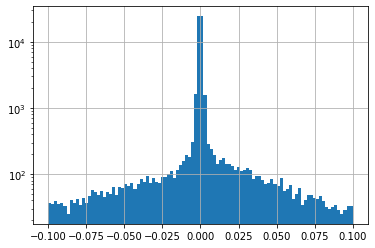

dphiNor


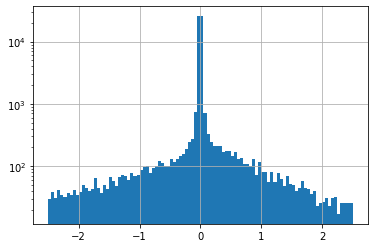

zinner


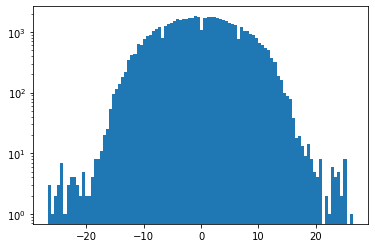

dz


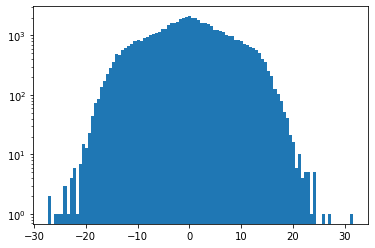

z0


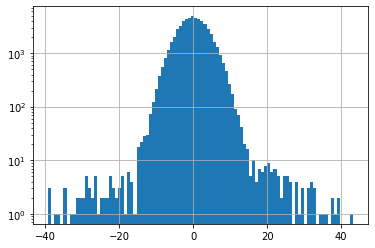

z0 res


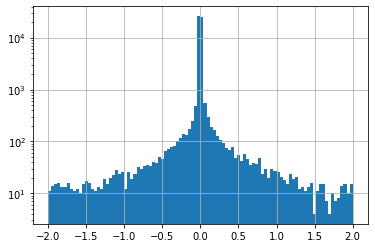

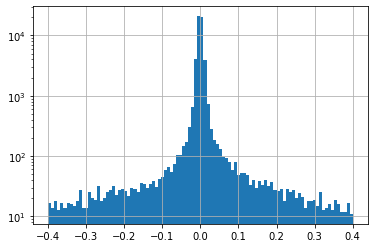

z0 pool


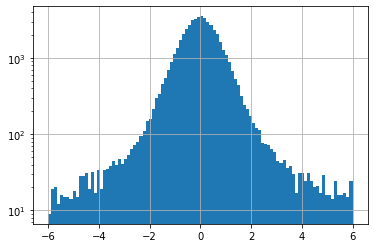

fit failed
dr


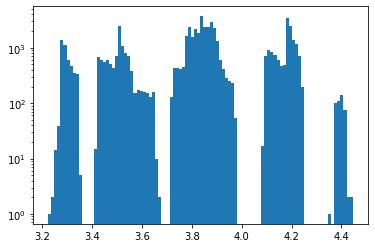

dphi zcut


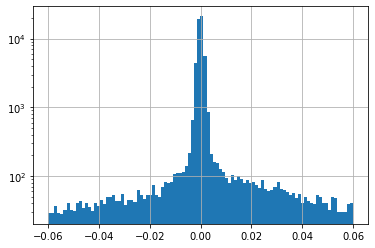

zinner zcut


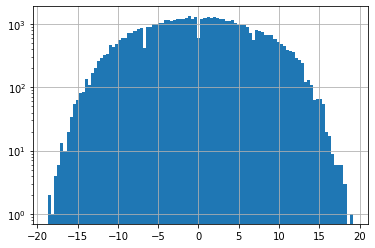

module


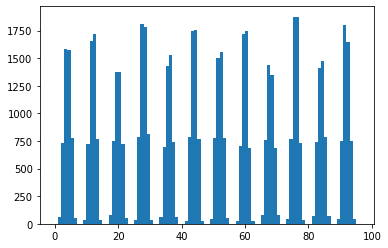

dysize


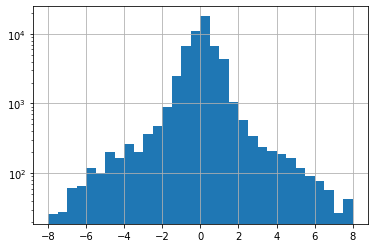

ysize


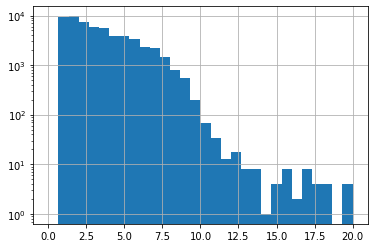

ys-pred


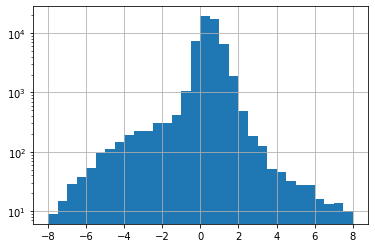

 
NEW PAIR 1 2 3
 
dphi


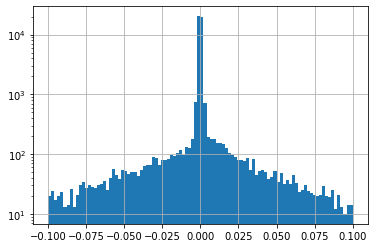

dphiNor


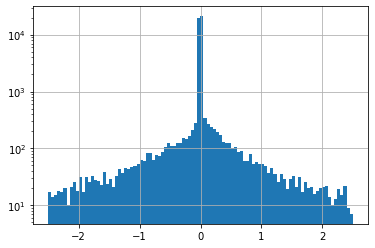

zinner


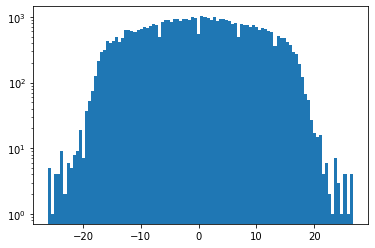

dz


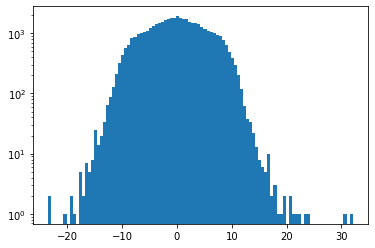

z0


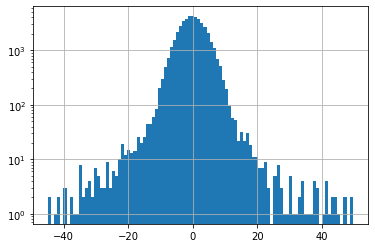

z0 res


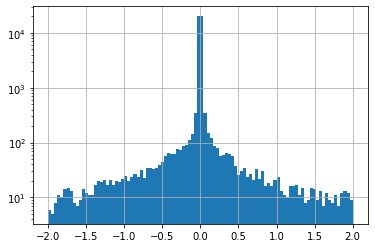

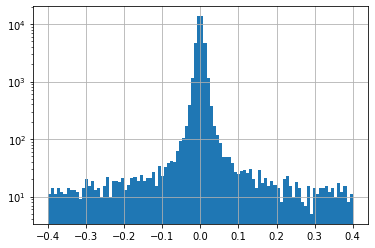

z0 pool


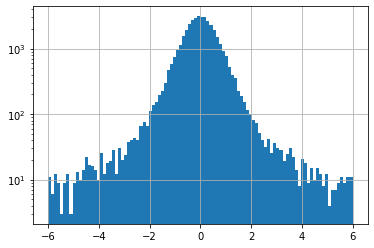

fit failed
dr


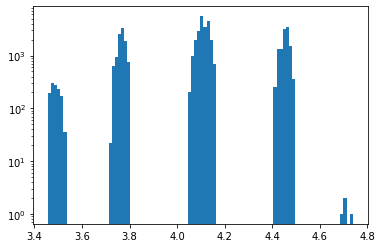

dphi zcut


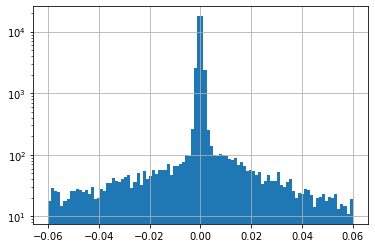

zinner zcut


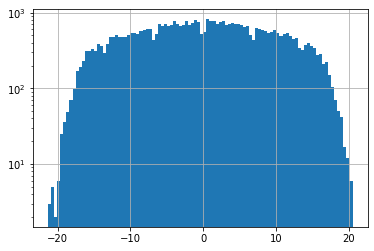

module


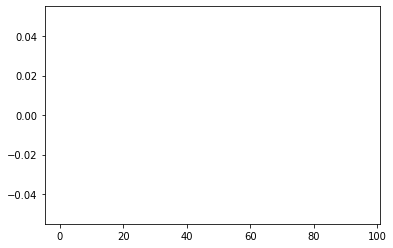

dysize


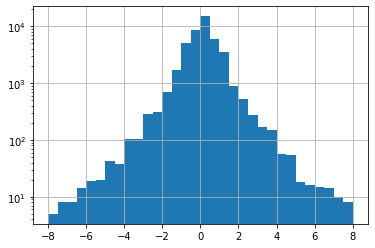

ysize


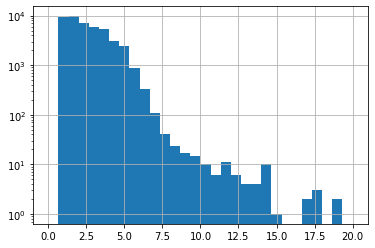

ys-pred


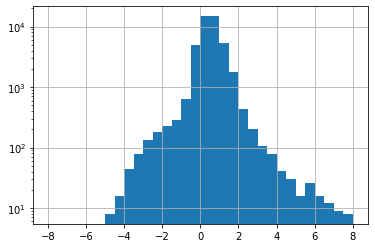

 
NEW PAIR 2 3 4
 
dphi


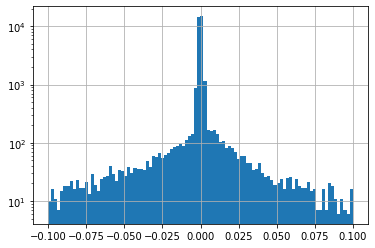

dphiNor


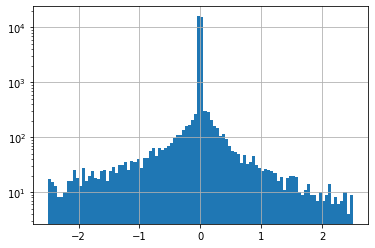

zinner


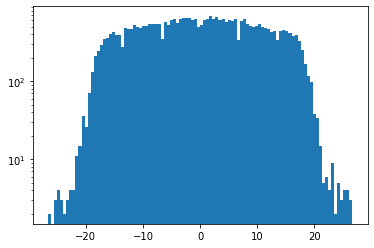

dz


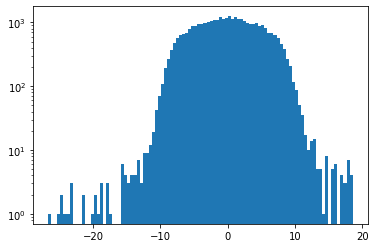

z0


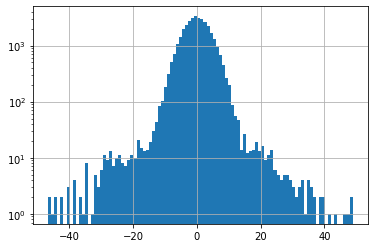

z0 res


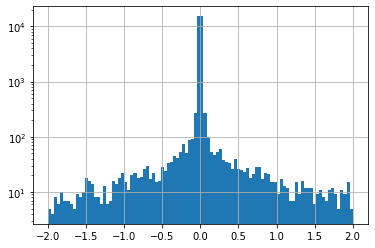

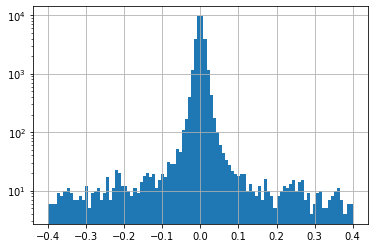

z0 pool


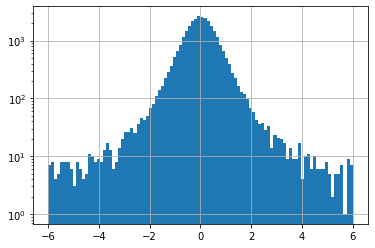

fit failed
dr


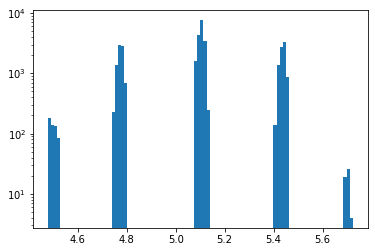

dphi zcut


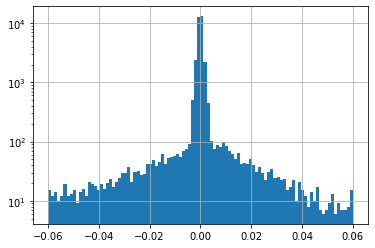

zinner zcut


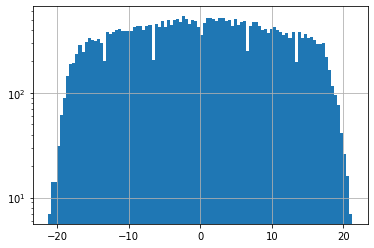

module


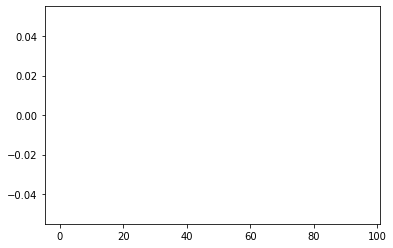

dysize


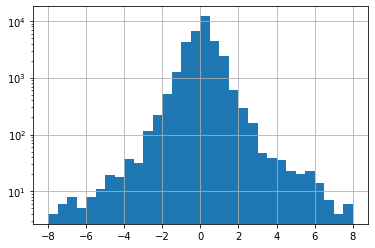

ysize


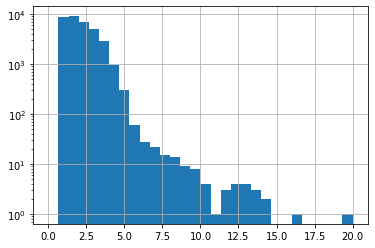

ys-pred


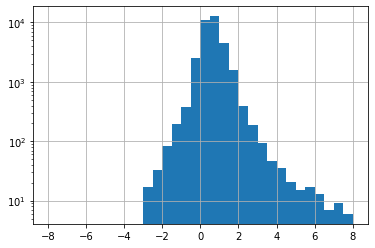

 
NEW PAIR 3 1 8
 
dphi


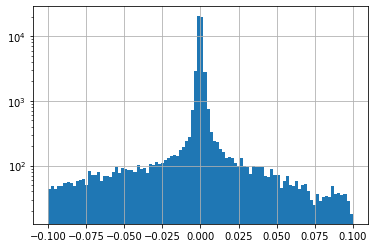

dphiNor


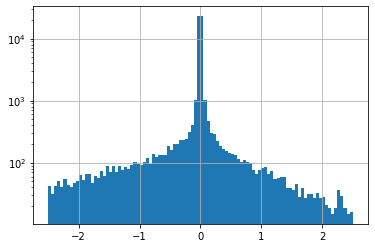

zinner


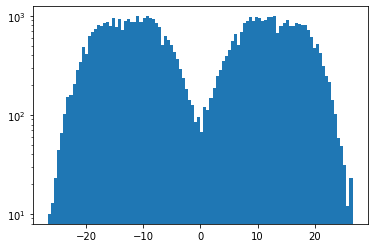

dz


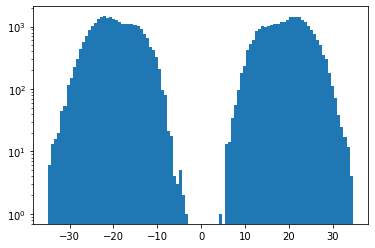

z0


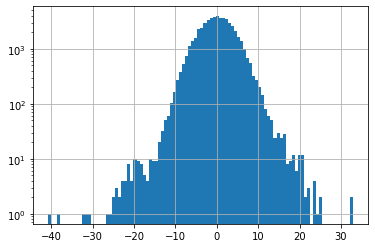

z0 res


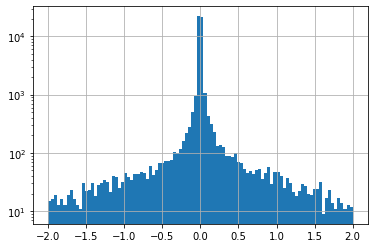

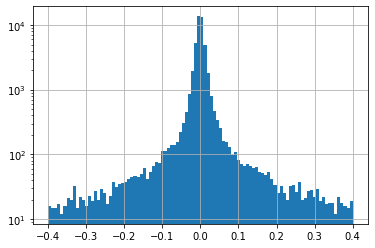

z0 pool


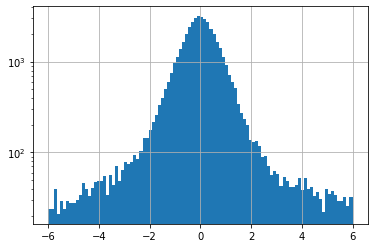

fit failed
dr


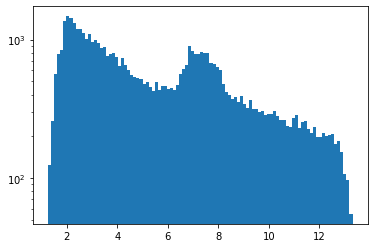

dphi zcut


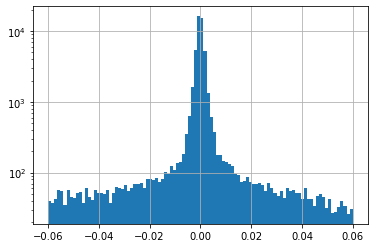

zinner zcut


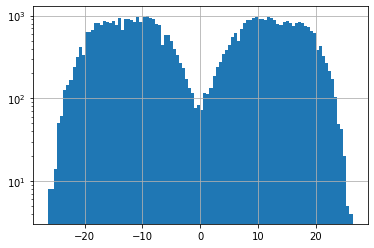

module


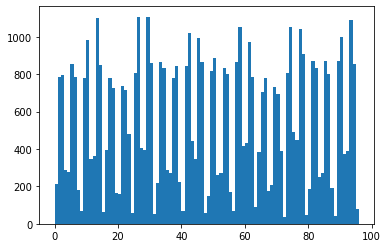

dysize


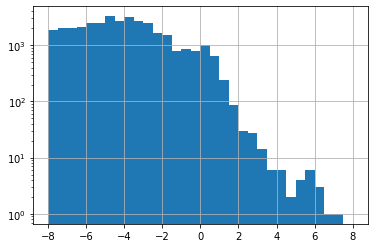

ysize


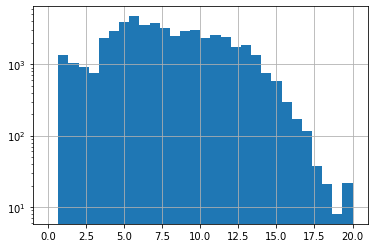

ys-pred


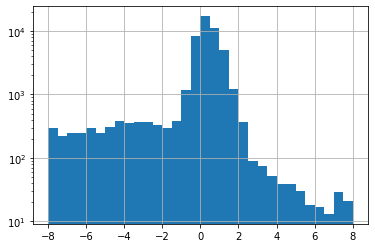

 
NEW PAIR 4 2 8
 
dphi


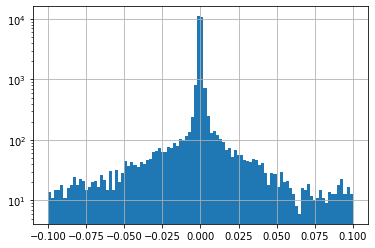

dphiNor


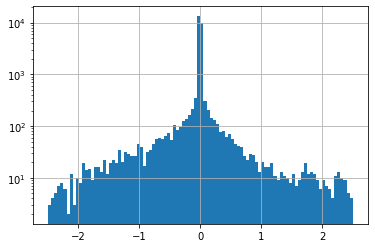

zinner


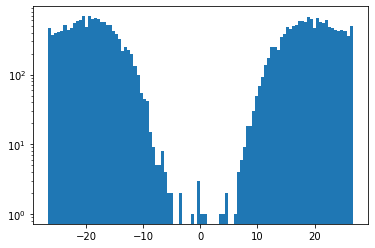

dz


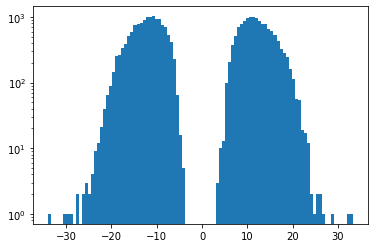

z0


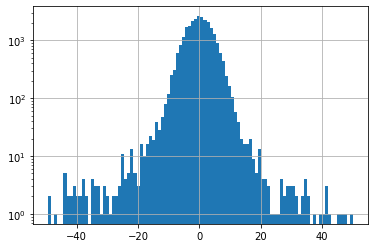

z0 res


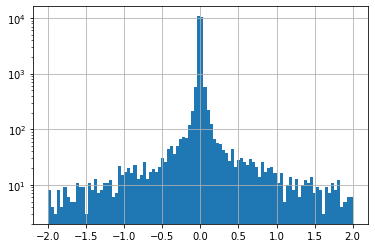

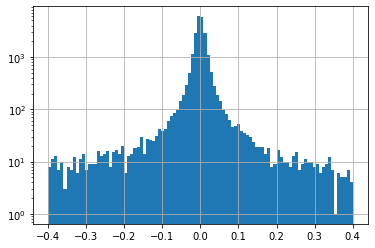

z0 pool


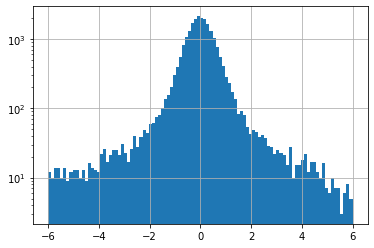

fit failed
dr


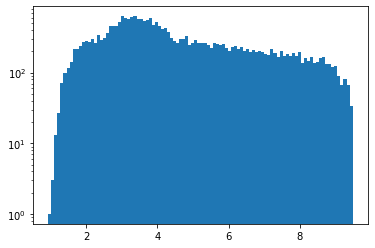

dphi zcut


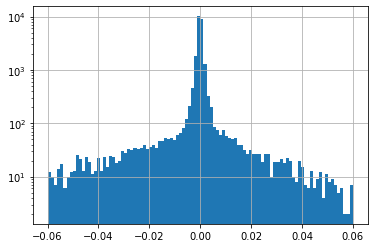

zinner zcut


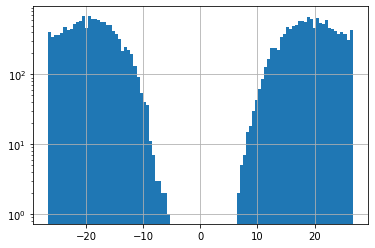

module


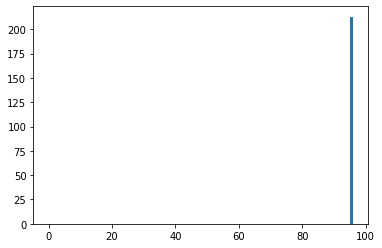

dysize


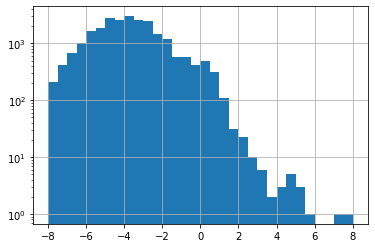

ysize


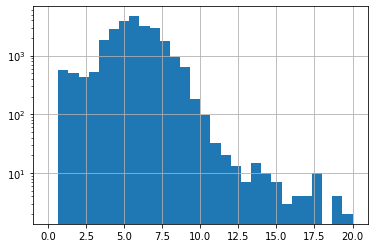

ys-pred


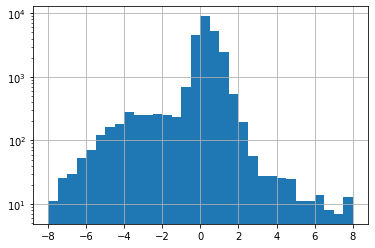

 
NEW PAIR 5 3 8
 
dphi


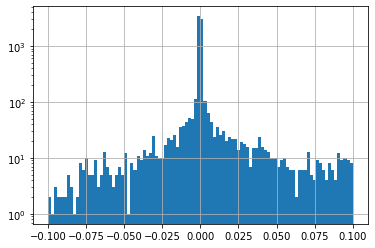

dphiNor


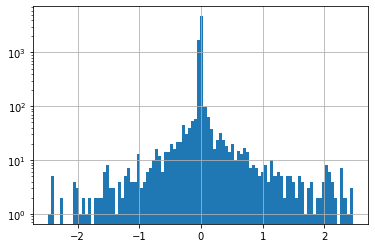

zinner


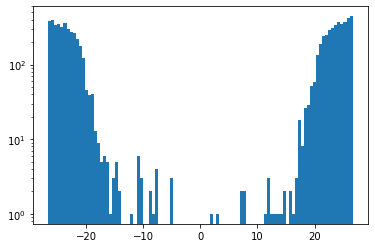

dz


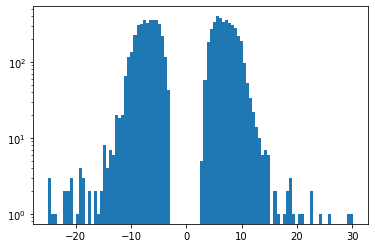

z0


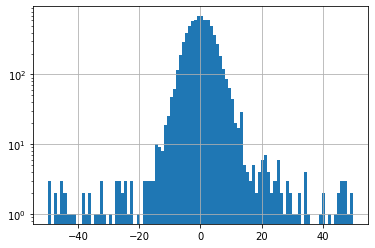

z0 res


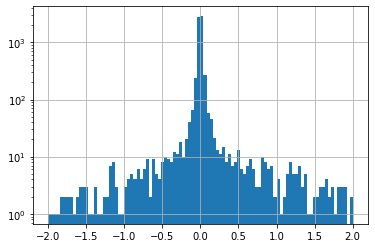

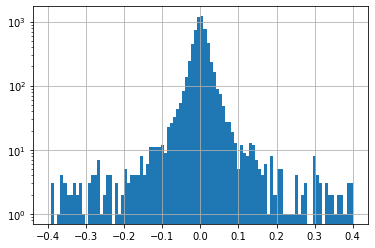

z0 pool


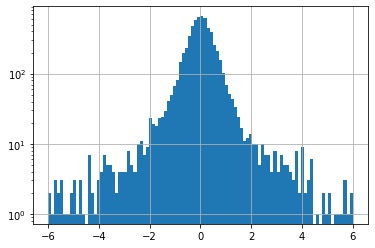

fit failed
dr


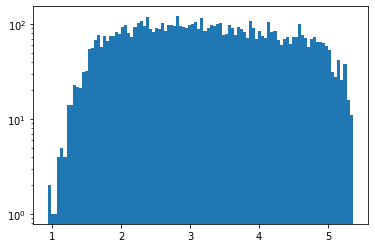

dphi zcut


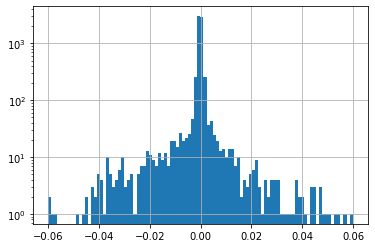

zinner zcut


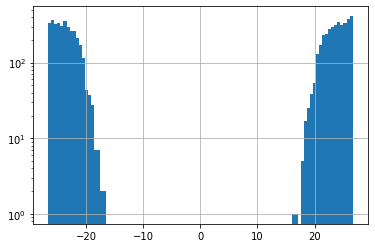

module


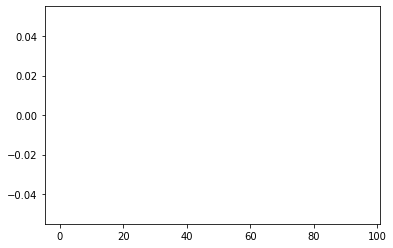

dysize


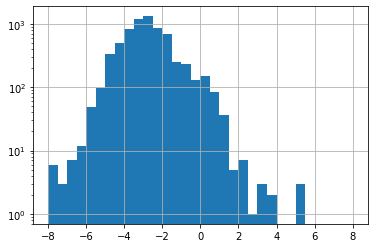

ysize


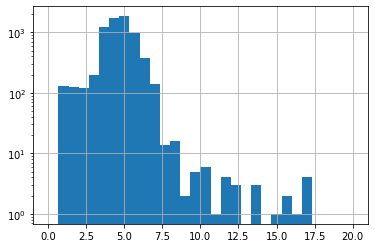

ys-pred


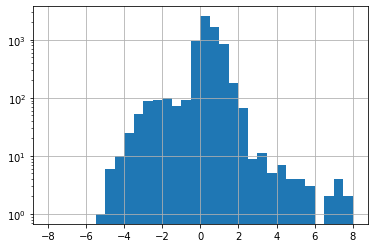

 
NEW PAIR 6 8 9
 
dphi


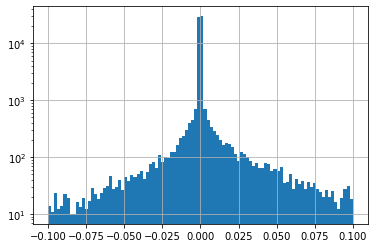

dphiNor


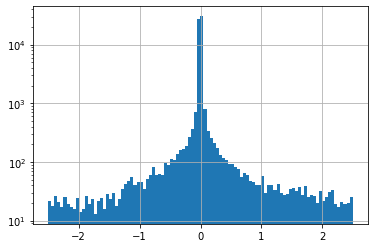

zinner


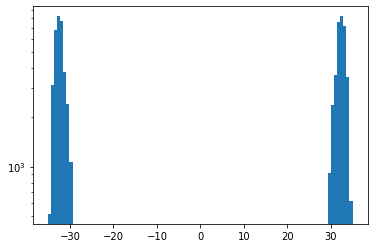

dz


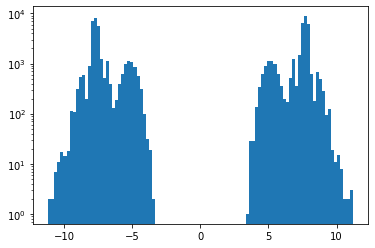

z0


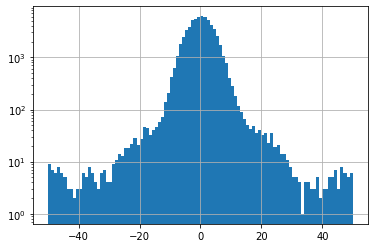

z0 res


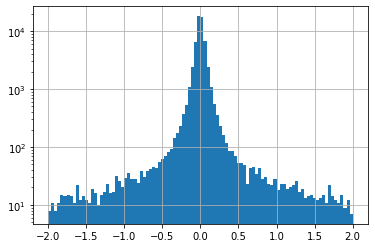

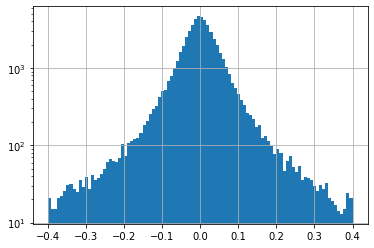

z0 pool


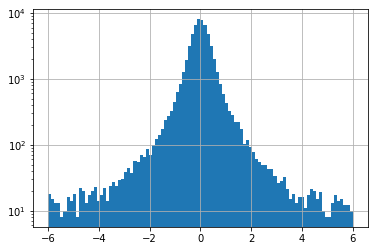

fit failed
dr


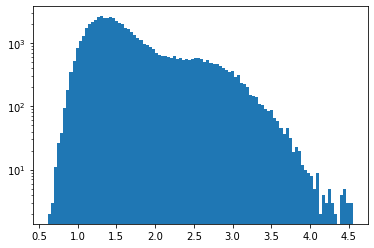

dphi zcut


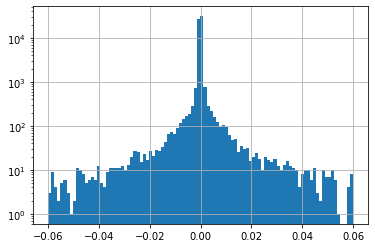

zinner zcut


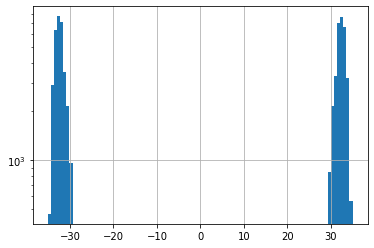

module


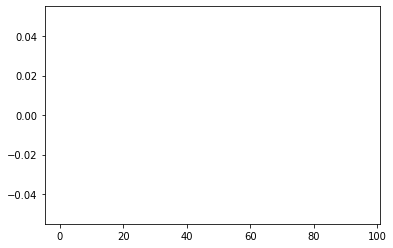

dysize


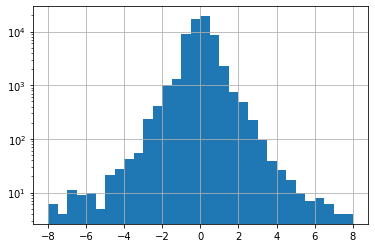

ysize


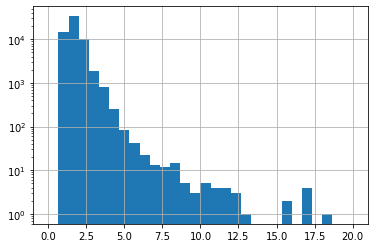

ys-pred


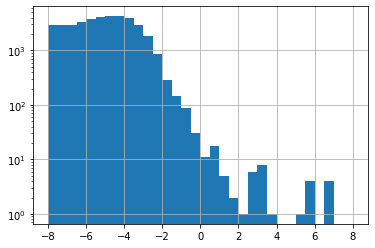

 
NEW PAIR 7 9 10
 
dphi


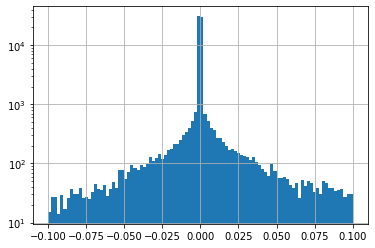

dphiNor


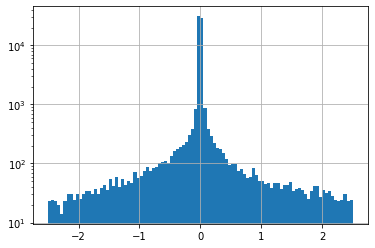

zinner


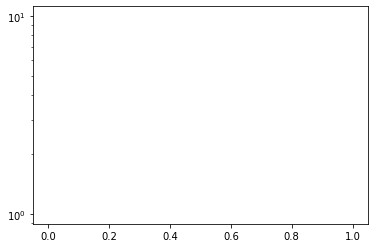

dz


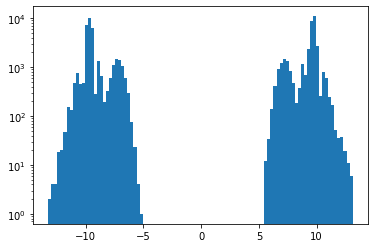

z0


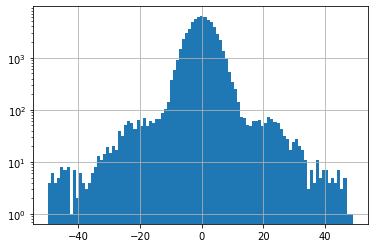

z0 res


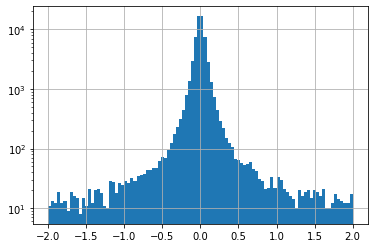

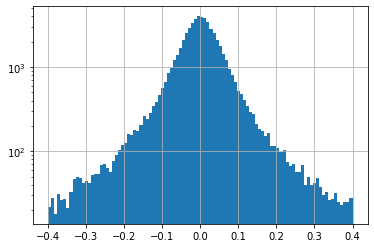

z0 pool


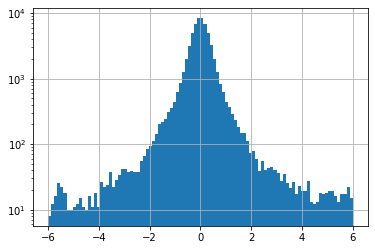

fit failed
dr


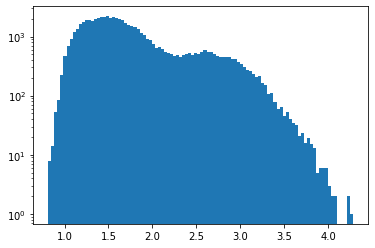

dphi zcut


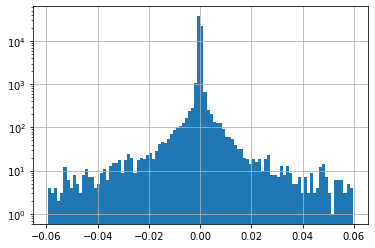

zinner zcut


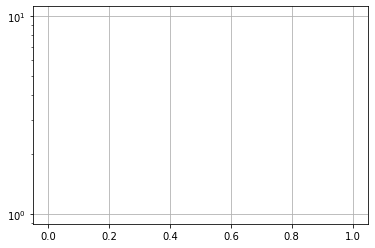

module


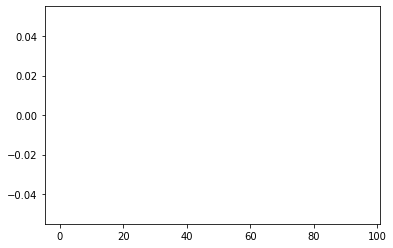

dysize


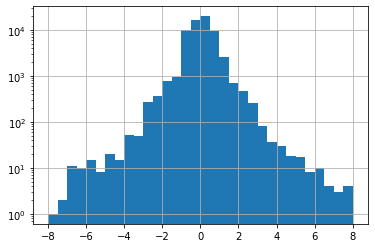

ysize


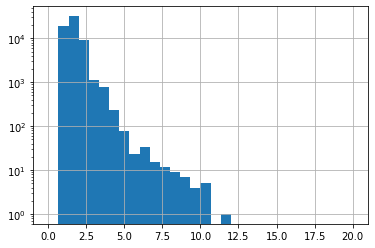

ys-pred


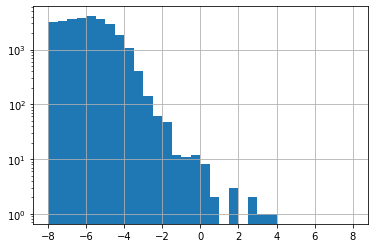

In [36]:
kp=0
for quad in lpairs :
  plotPairs(quad,400,kp)
  kp+=1